# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what *derivative sigmoid* has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

Так как, $$\nabla (f(x, y) + g(x, y)) = \nabla f(x, y) + \nabla g(x, y)$$
$\nabla_w L(w, w_0) = \nabla_w (\sum\limits^N_{i=1}-y_i\log\sigma(w^\top x_i) - (1-y_i)\log(1 - \sigma(w^\top x_i)) + \nabla_w (\gamma \|w\|_1) + \nabla_w (\beta \|w\|_2^2)$
$\nabla_w (\sum\limits^N_{i=1}-y_i\log\sigma(w^\top x_i) - (1-y_i)\log(1 - \sigma(w^\top x_i)) = \sum\limits^N_{i=1}\nabla_w(-y_i\log\sigma(w^\top x_i)) - \nabla_w((1-y_i)\log(1 - \sigma(w^\top x_i)))$

$\nabla_w(-y_i\log\sigma(w^\top x_i)) = \frac{-y_i}{\sigma(w^\top x_i)}\sigma(w^\top x_i)(1 - \sigma(w^\top x_i))x_i = -y_i (1 - \sigma(w^\top x_i))x_i$ \\

$\nabla_w(1-y_i)\log(1 - \sigma(w^\top x_i)) = -\frac{1 - y_i}{1 - \sigma(w^\top x_i)}\sigma(w^\top x_i)(1 - \sigma(w^\top x_i))x_i = (y_i - 1)\sigma(w^\top x_i)x_i$ \\

$-y_i (1 - \sigma(w^\top x_i)) - (y_i - 1)\sigma(w^\top x_i) = -y_i + y_i\sigma(w^\top x_i) - y_i\sigma(w^\top x_i) + \sigma(w^\top x_i) = (\sigma(w^\top x_i) - y_i)x_i$

Тогда:

$$\frac{\partial L}{\partial w} = \sum_{i=1}^{N}(\sigma(w^\top x_i) - y_i)x_i + \gamma \text{sign}(w) + 2\beta w$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [ ]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    # ravel использую, так как иногда возникают проблемы с размерностью и y_hat.shape то (N,), то (1, N)
    y_hat = np.ravel(sigmoid(np.dot(X, w)), order="F")
    return np.dot(-y, np.log(y_hat)) - np.dot((1 - y), np.log(1 - y_hat)) + gamma * np.sum(abs(w)) + beta * np.sum(w ** 2)

#### 3. [0.25 points] Implement the gradient (as a function)

In [ ]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> List[float]:
    y_hat = np.ravel(sigmoid(np.dot(X, w)), order="F")
    return np.dot(X.T, y_hat - y) + gamma * np.sign(w) + 2 * beta * w

#### Check yourself

In [ ]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)
grad_w = get_grad(X, y, w)
print(grad_w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

[-3.99447493 -1.84786723  0.64520104  1.67059973 -5.03858487 -5.21496336]


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, learning_rate=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        np.random.seed(random_state)
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.w = None
        self.loss_history = None

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        self.loss_history = []
        X = np.c_[np.ones(X.shape[0]), X]
        self.w = np.random.normal(size=X.shape[1])
        for it in range(self.max_iter):
          gradient = get_grad(X, y, self.w, self.beta, self.gamma)
          loss_val = loss(X, y, self.w)
          self.loss_history.append(loss_val)
          diff = np.ravel(-self.learning_rate * gradient, order="F")
          if np.all(np.abs(diff) <= self.tolerance):
              break
          self.w += diff

        return self

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        # your code here
        X = np.c_[np.ones(X.shape[0]), X]
        return np.ravel(np.round(sigmoid(np.dot(X, self.w))), order="F")

    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        X = np.c_[np.ones(X.shape[0]), X]
        return np.array([1 / (1 + np.exp(np.ravel(np.dot(X, self.w), order="F"))),\
                         1 / (1 + np.exp(-np.ravel(np.dot(X, self.w), order="F")))])

In [ ]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [ ]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

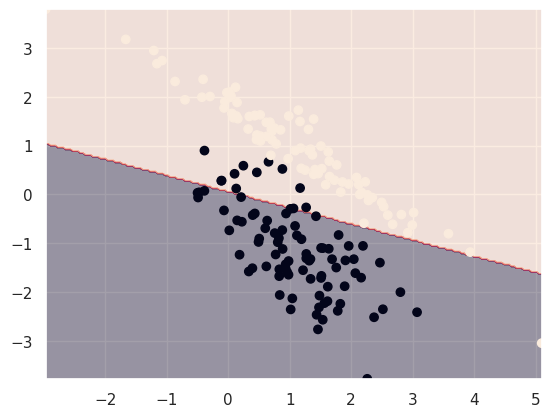

In [ ]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

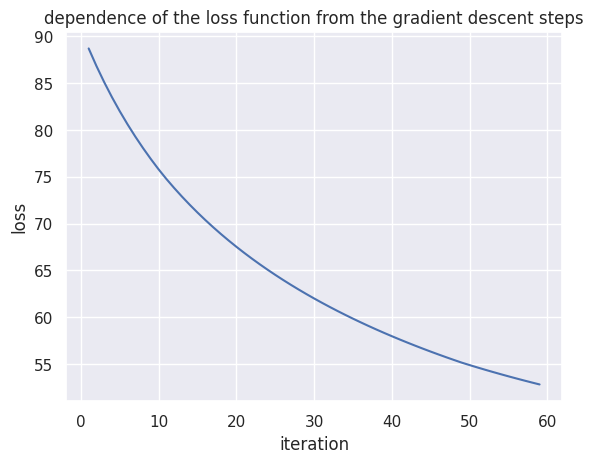

In [ ]:
x = np.arange(1, len(model.loss_history) + 1, 1)

plt.plot(x, model.loss_history)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("dependence of the loss function from the gradient descent steps")
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

!!! Старался отвечать на вопросы сразу после некоторых графиков

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

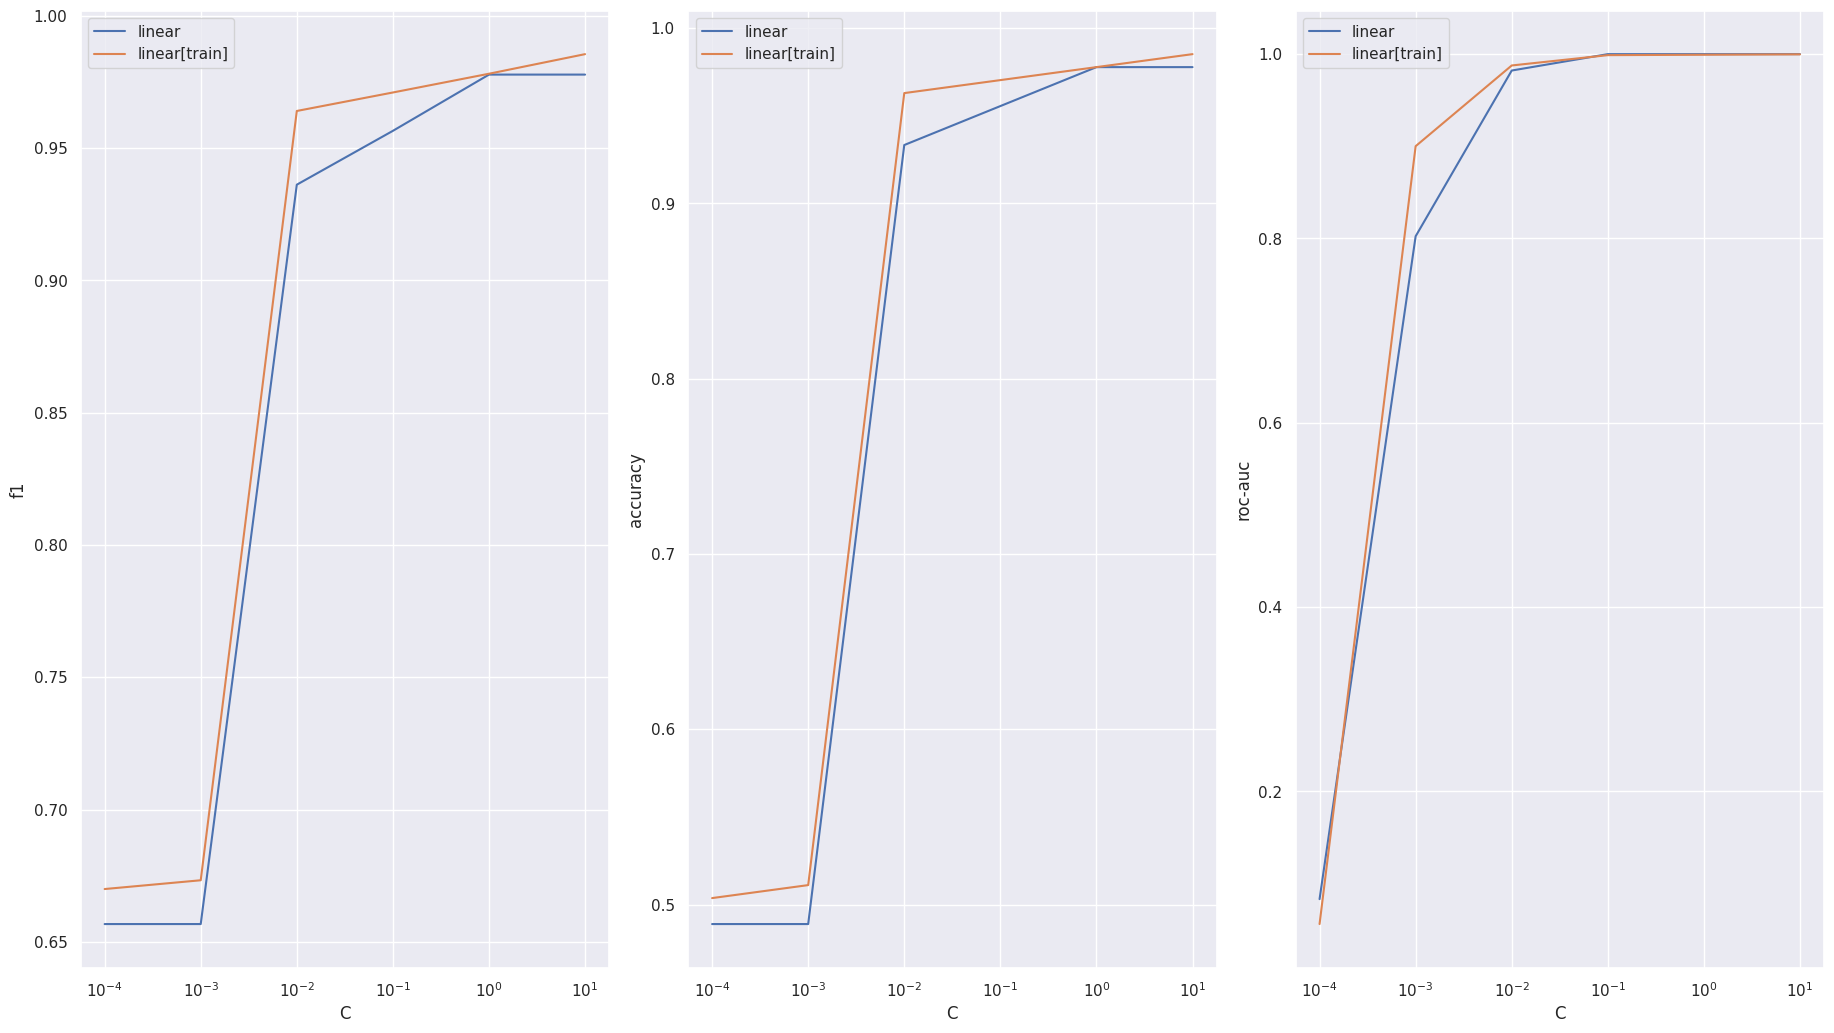

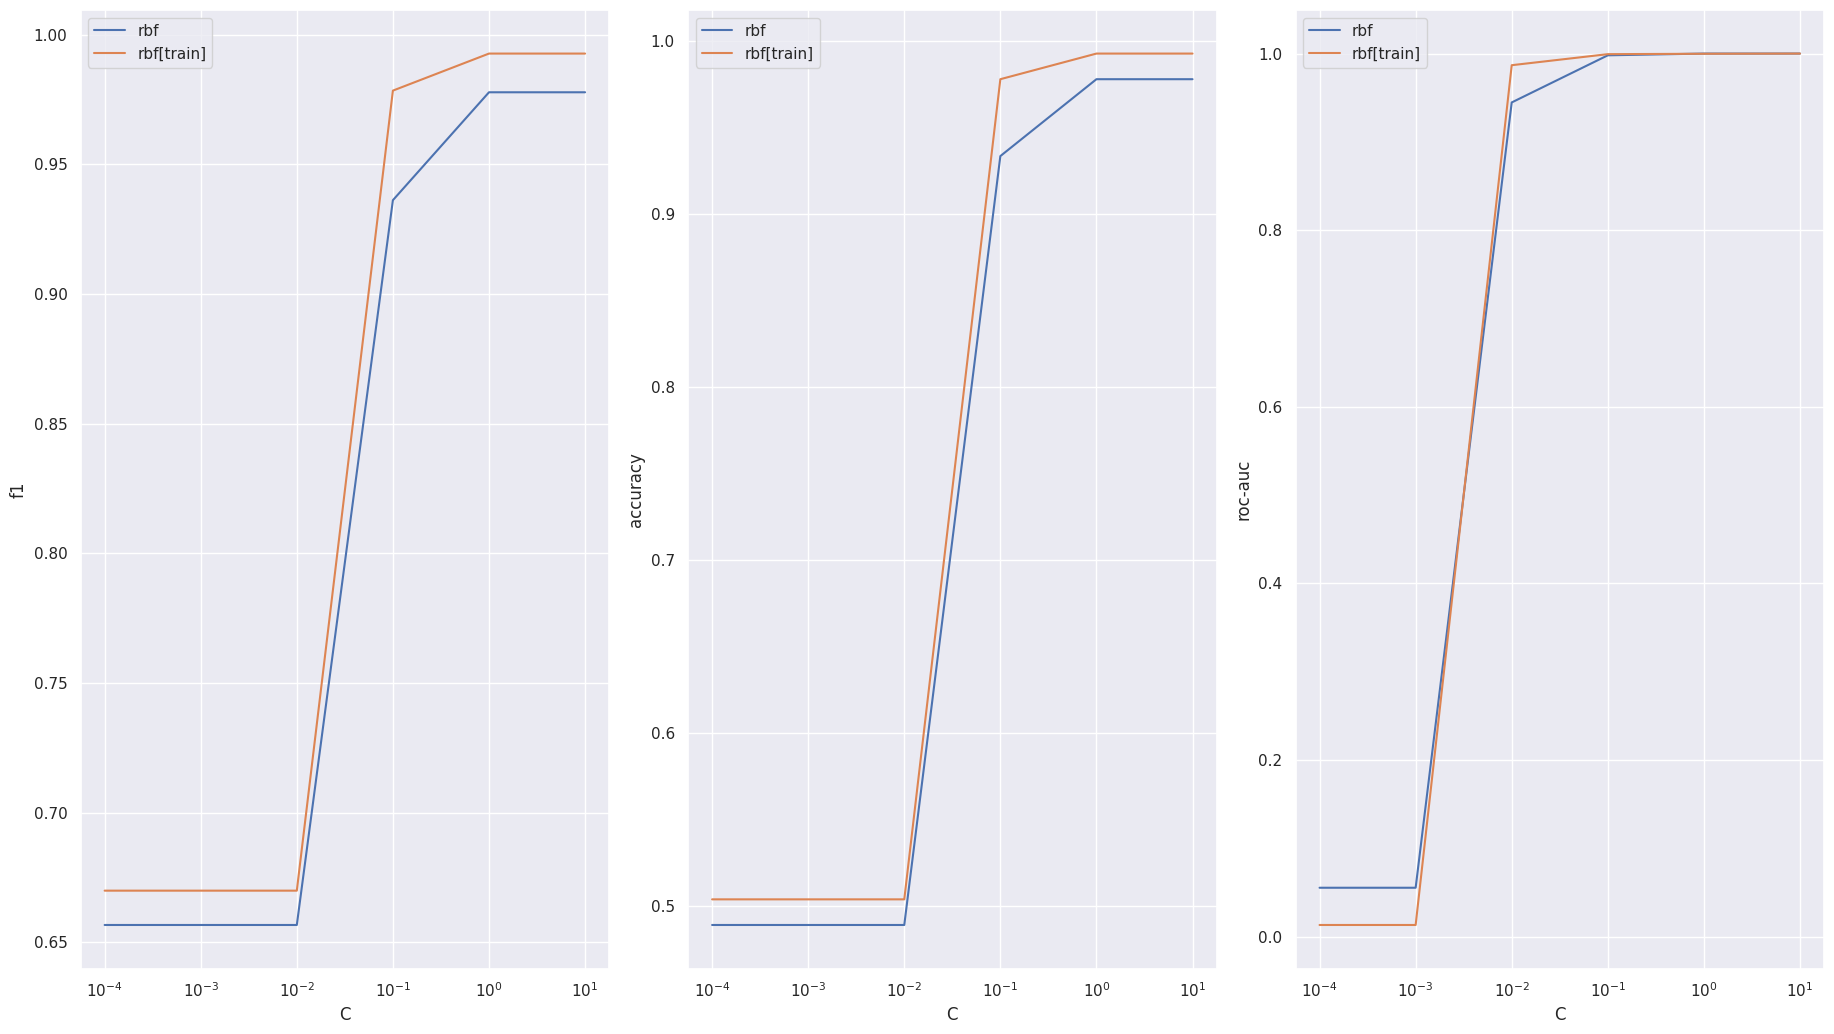

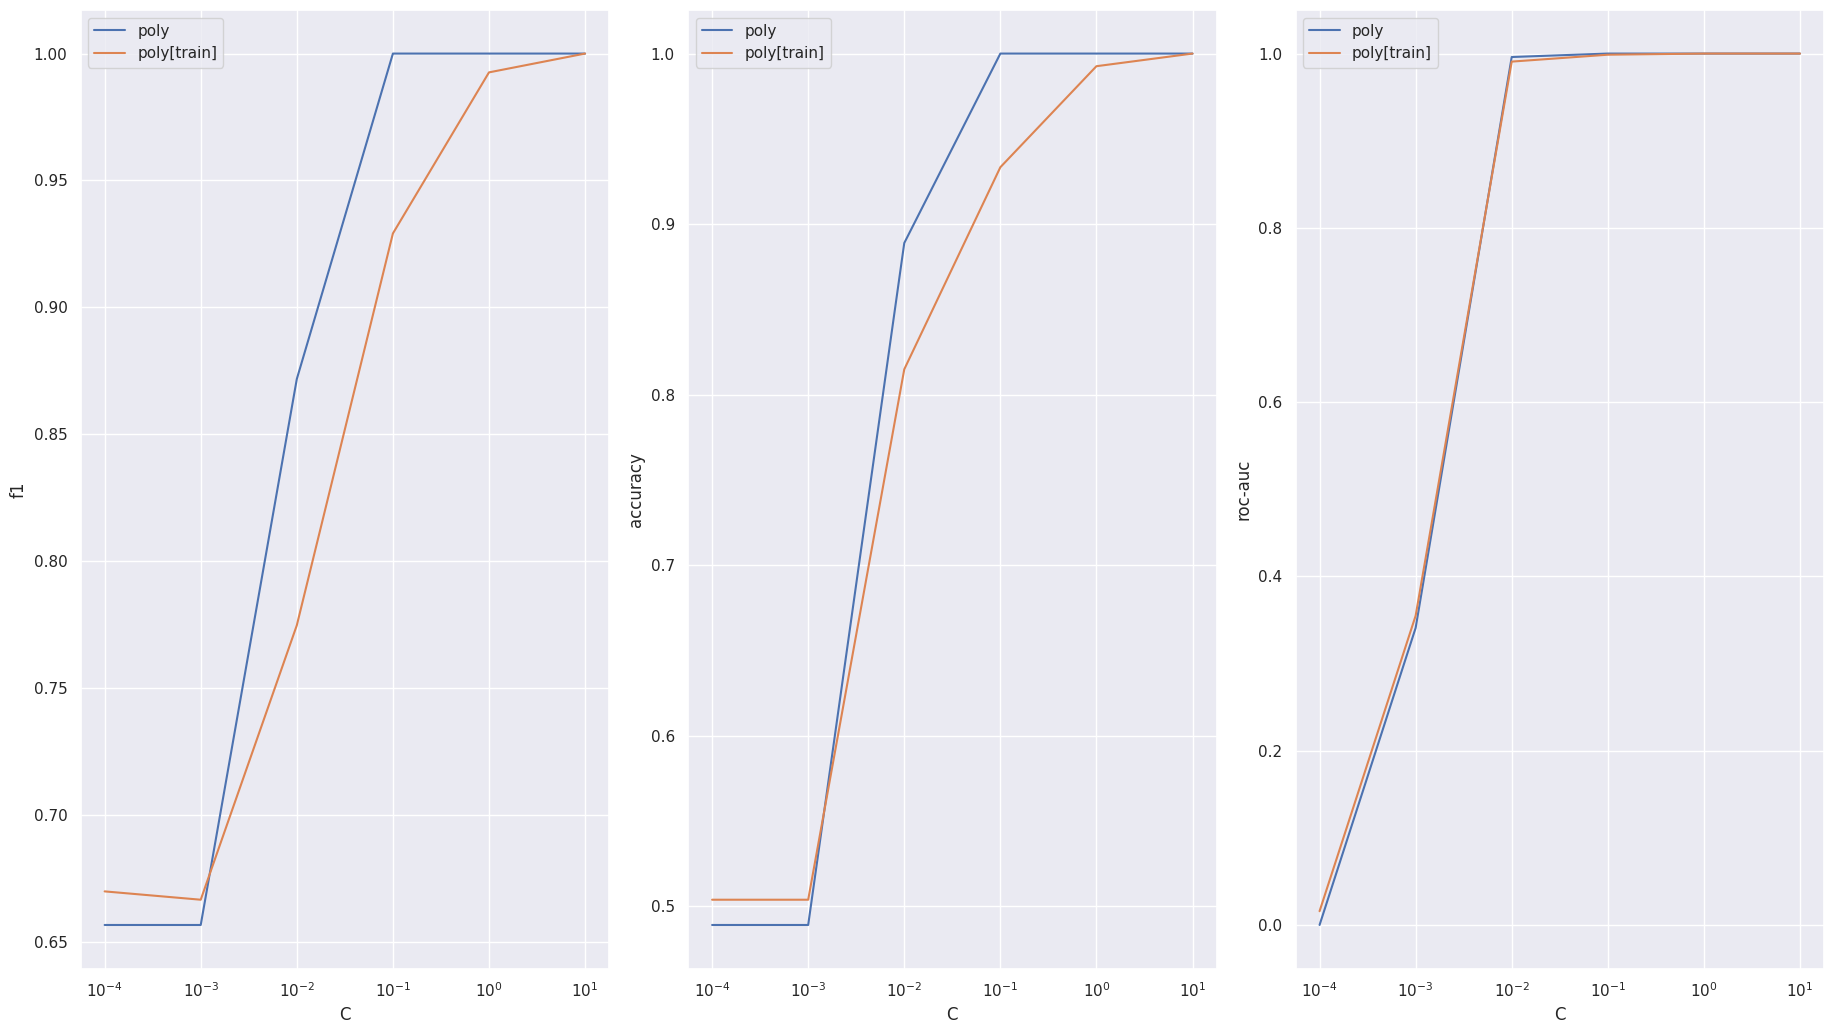

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
metrics = ["f1", "accuracy", "roc-auc"]
kernels = ["linear", "rbf", "poly"]
parameters = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'degree': [1, 2, 3, 4, 5],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'coef0': [-1, -0.5, 0, 0.5, 1, 10]
}

results = {metric: {x: {y: [] for y in parameters} for x in kernels} for metric in metrics}
result_train = {metric: {x: {y: [] for y in parameters} for x in kernels} for metric in metrics}
for kernel in kernels:
    for C in parameters['C']:
        svc = SVC(kernel=kernel, C=C, probability=True, verbose = False)
        svc.fit(X_train, y_train)

        y_pred = svc.predict(X_test)
        y_pred_proba = svc.predict_proba(X_test)
        results["accuracy"][kernel]["C"].append(accuracy_score(y_test, y_pred))
        results["f1"][kernel]["C"].append(f1_score(y_test, y_pred))
        results["roc-auc"][kernel]["C"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))

        y_pred_t = svc.predict(X_train)
        y_pred_proba_t = svc.predict_proba(X_train)
        result_train["accuracy"][kernel]["C"].append(accuracy_score(y_train, y_pred_t))
        result_train["f1"][kernel]["C"].append(f1_score(y_train, y_pred_t))
        result_train["roc-auc"][kernel]["C"].append(roc_auc_score(y_train, y_pred_proba_t[:, 1]))

for kernel in kernels:
    fig, axes = plt.subplots(ncols=3, nrows=1)
    fig.set_size_inches(18.5, 10.5)
    for i, metric in enumerate(metrics):
        axes[i].plot(parameters["C"], results[metric][kernel]["C"], label=kernel)
        axes[i].plot(parameters["C"], result_train[metric][kernel]["C"], label=kernel + "[train]")
        axes[i].set_xscale("log")
        axes[i].set_xlabel("C")
        axes[i].set_ylabel(metric)
        axes[i].legend(loc="upper left")
    plt.tight_layout()

При стандартных параметрах наиболее сколнными к переобучению оказываются линейное ядро и "rbf". Причем, судя по расхождению линий на графиках, "rbf" чуть более склонна

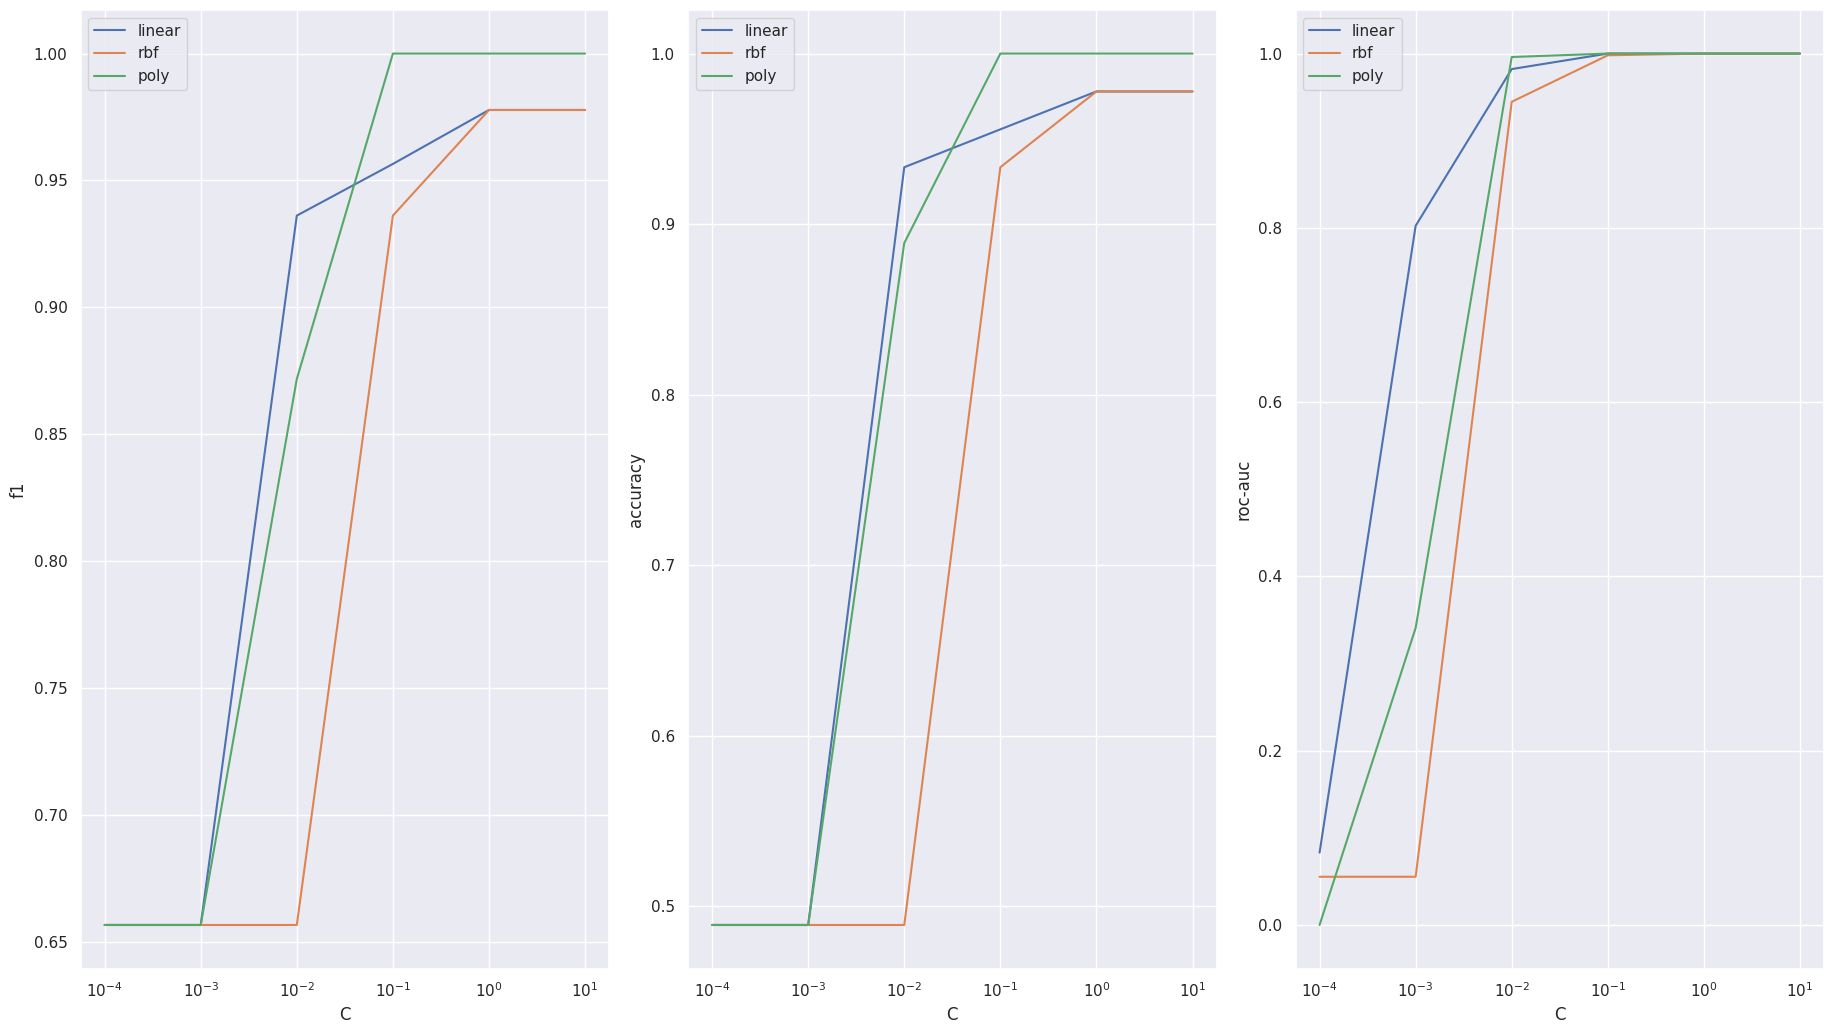

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)
for i, metric in enumerate(metrics):
    for kernel in kernels:
        axes[i].plot(parameters["C"], results[metric][kernel]["C"], label=kernel)
        axes[i].set_xscale("log")
        axes[i].set_xlabel("C")
        axes[i].set_ylabel(metric)
        axes[i].legend(loc="upper left")
plt.tight_layout()

С увеличением коэффициента регуляризации все модели (при остальных параметрах по умолчанию) начинают показывать хороший результат

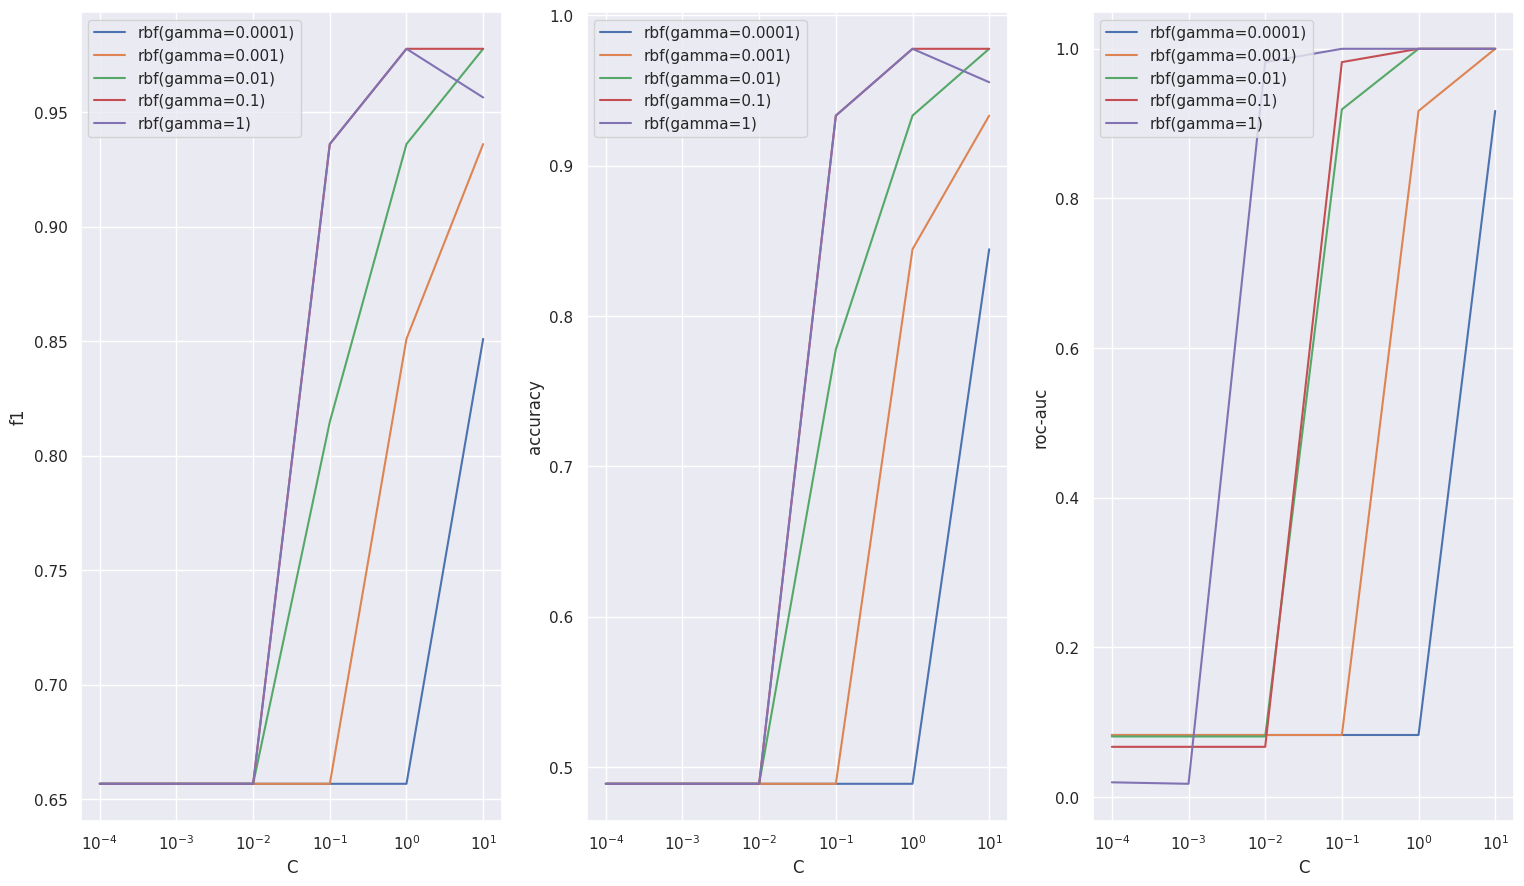

In [ ]:
# Отедльно влияние гиперпараметра gamma на rbf
# y - score, x - C, lines - rbf with gamma
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)

scores = {x: [] for x in metrics}
for gamma in parameters['gamma']:
    for c in parameters['C']:
        svc = SVC(kernel="rbf", gamma=gamma, C=c, probability=True, verbose=False)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        y_pred_proba = svc.predict_proba(X_test)
        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["f1"].append(f1_score(y_test, y_pred))
        scores["roc-auc"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    for i, metric in enumerate(metrics):
        axes[i].plot(parameters['C'], scores[metric], label=f"rbf(gamma={gamma})")
        axes[i].set_xscale("log")
        axes[i].set_xlabel("C")
        axes[i].set_ylabel(metric)
        axes[i].legend(loc="upper left")
        scores[metric].clear()

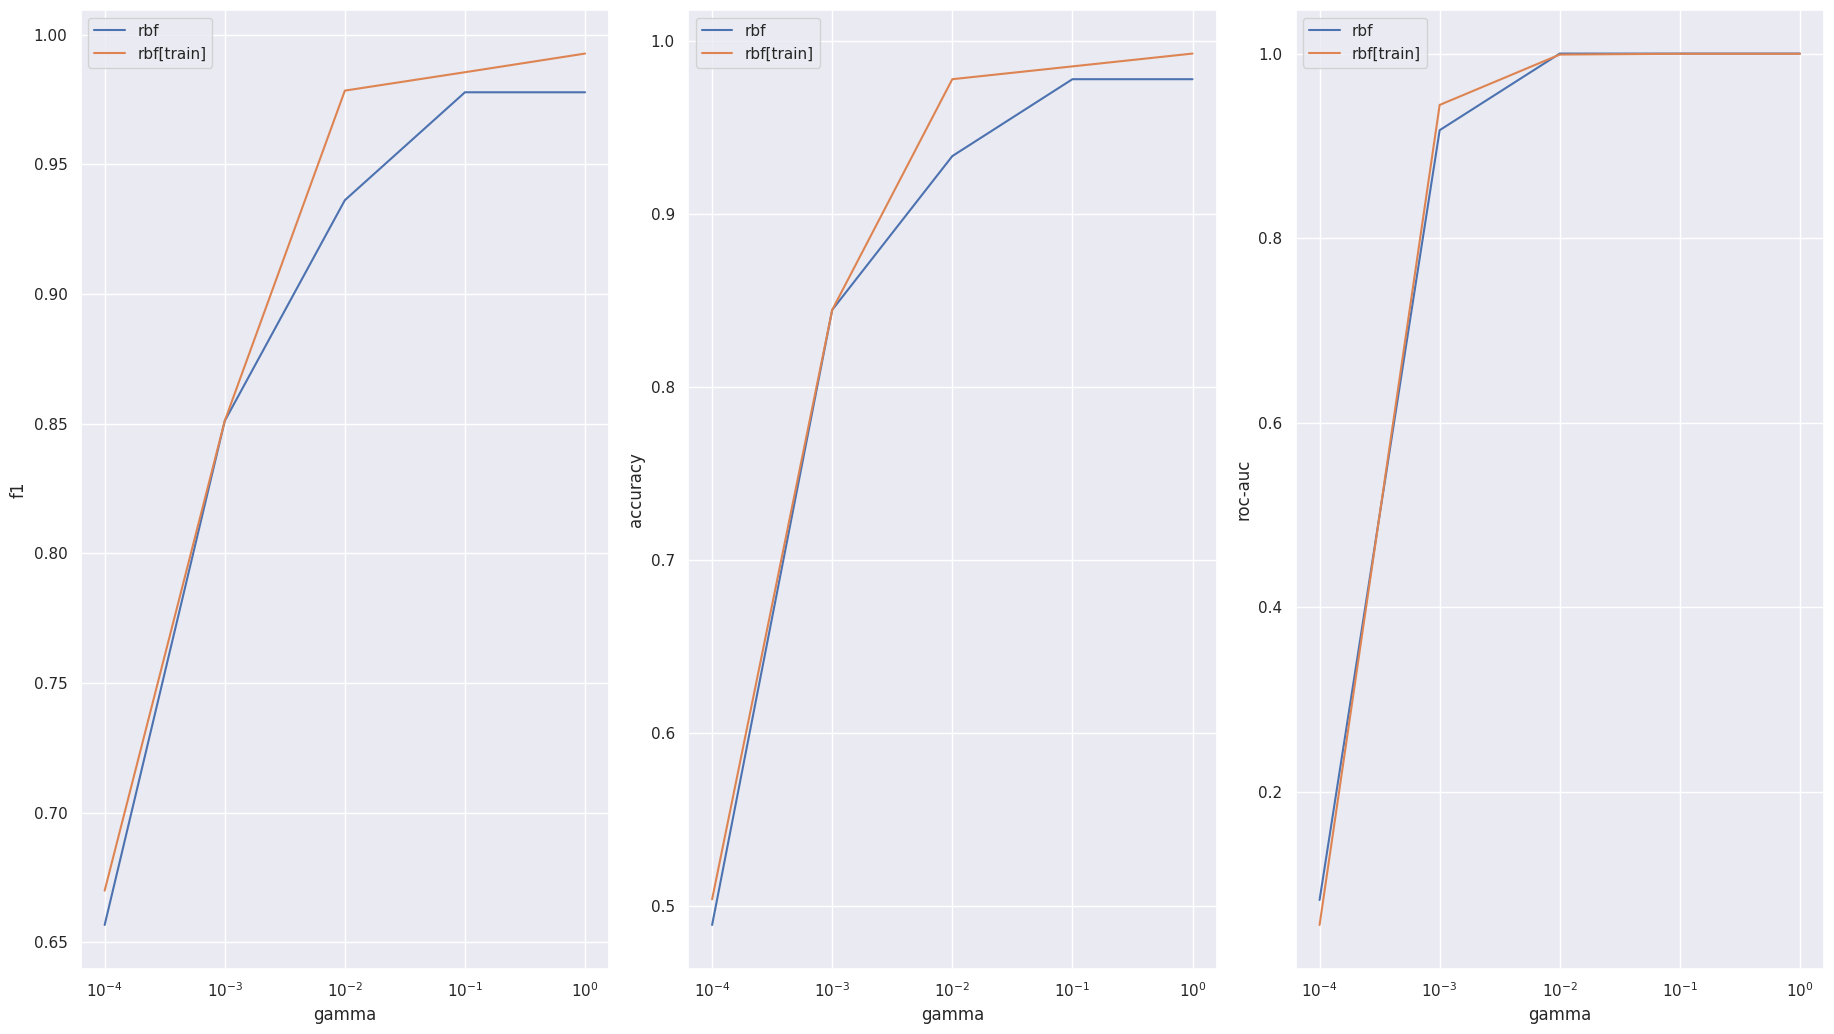

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)

scores_train = {x: [] for x in metrics}
for gamma in parameters['gamma']:
    svc = SVC(kernel="rbf", gamma=gamma, probability=True, verbose = False)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_pred_proba = svc.predict_proba(X_test)
    results["accuracy"]["rbf"]["gamma"].append(accuracy_score(y_test, y_pred))
    results["f1"]["rbf"]["gamma"].append(f1_score(y_test, y_pred))
    results["roc-auc"]["rbf"]["gamma"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))

    y_pred_t = svc.predict(X_train)
    y_pred_proba_t = svc.predict_proba(X_train)
    scores_train["accuracy"].append(accuracy_score(y_train, y_pred_t))
    scores_train["f1"].append(f1_score(y_train, y_pred_t))
    scores_train["roc-auc"].append(roc_auc_score(y_train, y_pred_proba_t[:, 1]))

kernel="rbf"
for i, metric in enumerate(metrics):
    axes[i].plot(parameters["gamma"], results[metric][kernel]["gamma"], label=kernel)
    axes[i].plot(parameters["gamma"], scores_train[metric], label=kernel + "[train]")
    axes[i].set_xscale("log")
    axes[i].set_xlabel("gamma")
    axes[i].set_ylabel(metric)
    axes[i].legend(loc="upper left")
plt.tight_layout()

RBF чувстительно к параметру гамма, с его уменьшением качество модели заметно падает

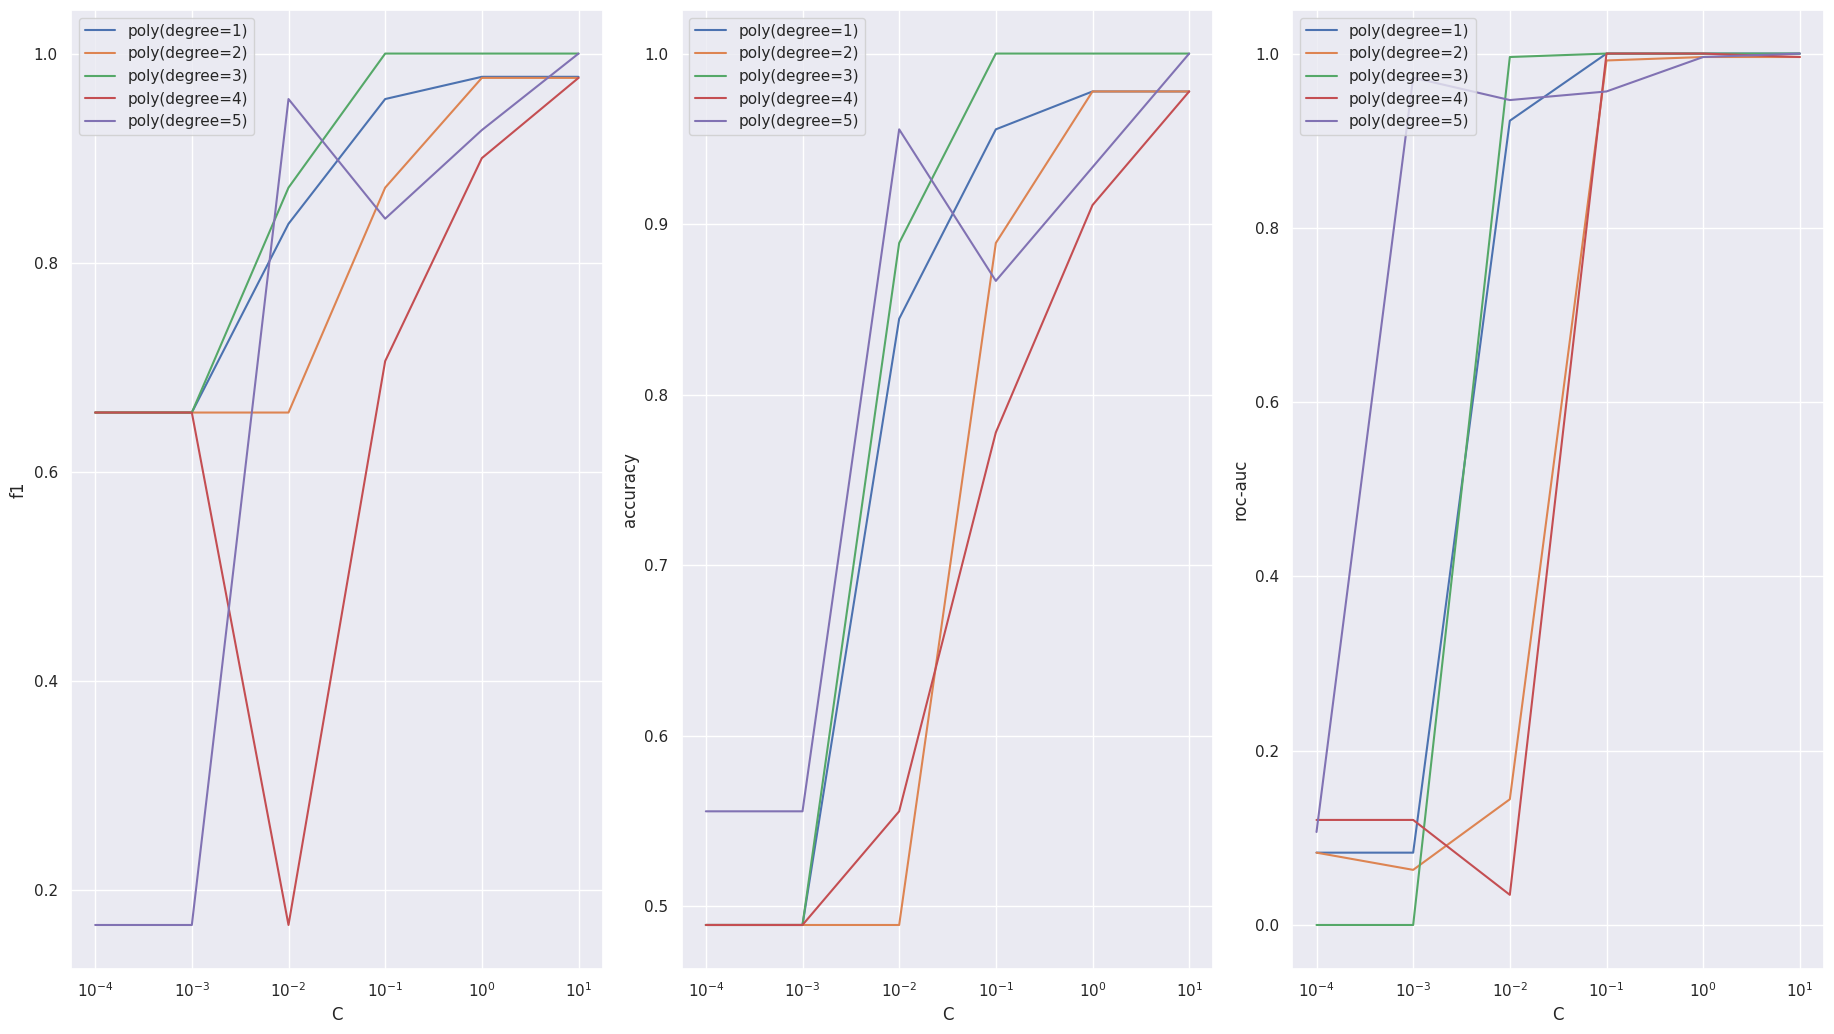

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)

scores = {x: [] for x in metrics}
for d in parameters['degree']:
    for c in parameters['C']:
        svc = SVC(kernel="poly", degree=d, C=c, probability=True, verbose=False)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        y_pred_proba = svc.predict_proba(X_test)
        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["f1"].append(f1_score(y_test, y_pred))
        scores["roc-auc"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    for i, metric in enumerate(metrics):
        axes[i].plot(parameters['C'], scores[metric], label=f"poly(degree={d})")
        axes[i].set_xscale("log")
        axes[i].set_xlabel("C")
        axes[i].set_ylabel(metric)
        axes[i].legend(loc="upper left")
        scores[metric].clear()
plt.tight_layout()

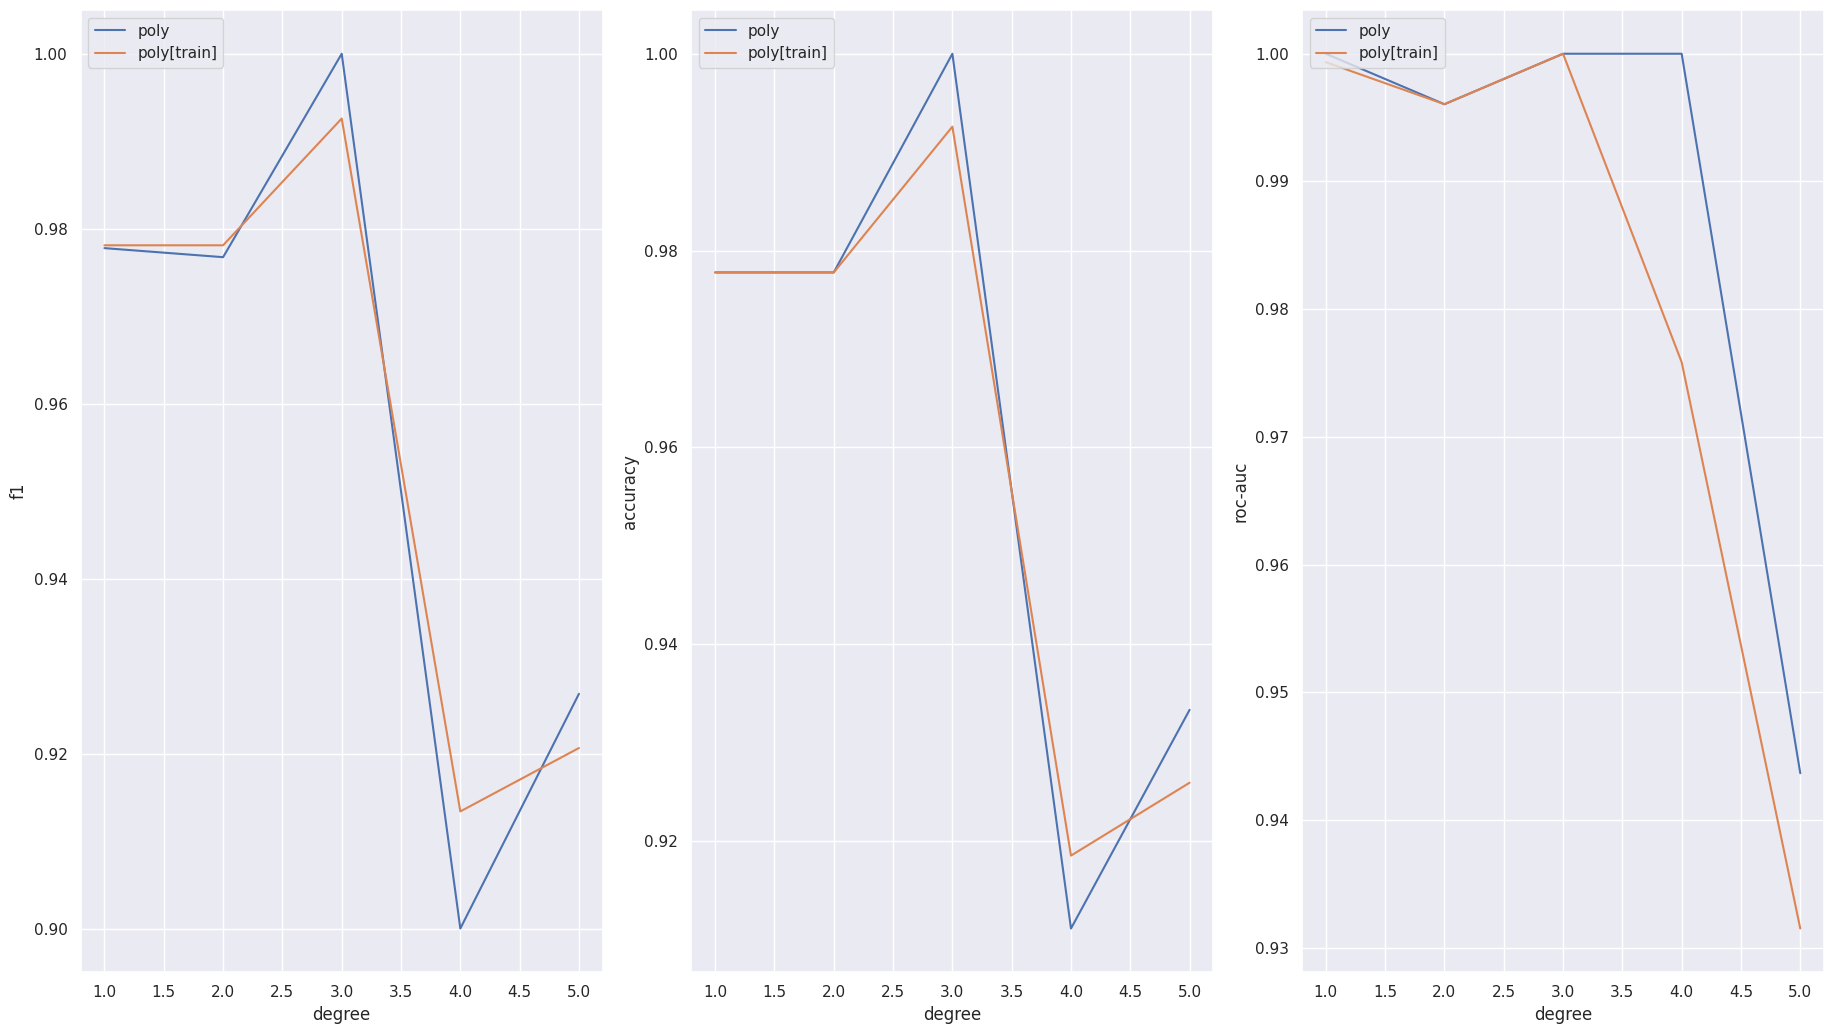

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)

scores = {x: [] for x in metrics}
scores_train = {x: [] for x in metrics}
for d in parameters['degree']:
    svc = SVC(kernel="poly", degree=d, probability=True, verbose=False)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_pred_proba = svc.predict_proba(X_test)
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["f1"].append(f1_score(y_test, y_pred))
    scores["roc-auc"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))

    y_pred_t = svc.predict(X_train)
    y_pred_proba_t = svc.predict_proba(X_train)
    scores_train["accuracy"].append(accuracy_score(y_train, y_pred_t))
    scores_train["f1"].append(f1_score(y_train, y_pred_t))
    scores_train["roc-auc"].append(roc_auc_score(y_train, y_pred_proba_t[:, 1]))
for i, metric in enumerate(metrics):
    axes[i].plot(parameters['degree'], scores[metric], label=f"poly")
    axes[i].plot(parameters['degree'], scores_train[metric], label=f"poly[train]")
    axes[i].set_xlabel("degree")
    axes[i].set_ylabel(metric)
    axes[i].legend(loc="upper left")
    scores[metric].clear()
plt.tight_layout()

В качестве степени лучше всего степень 3

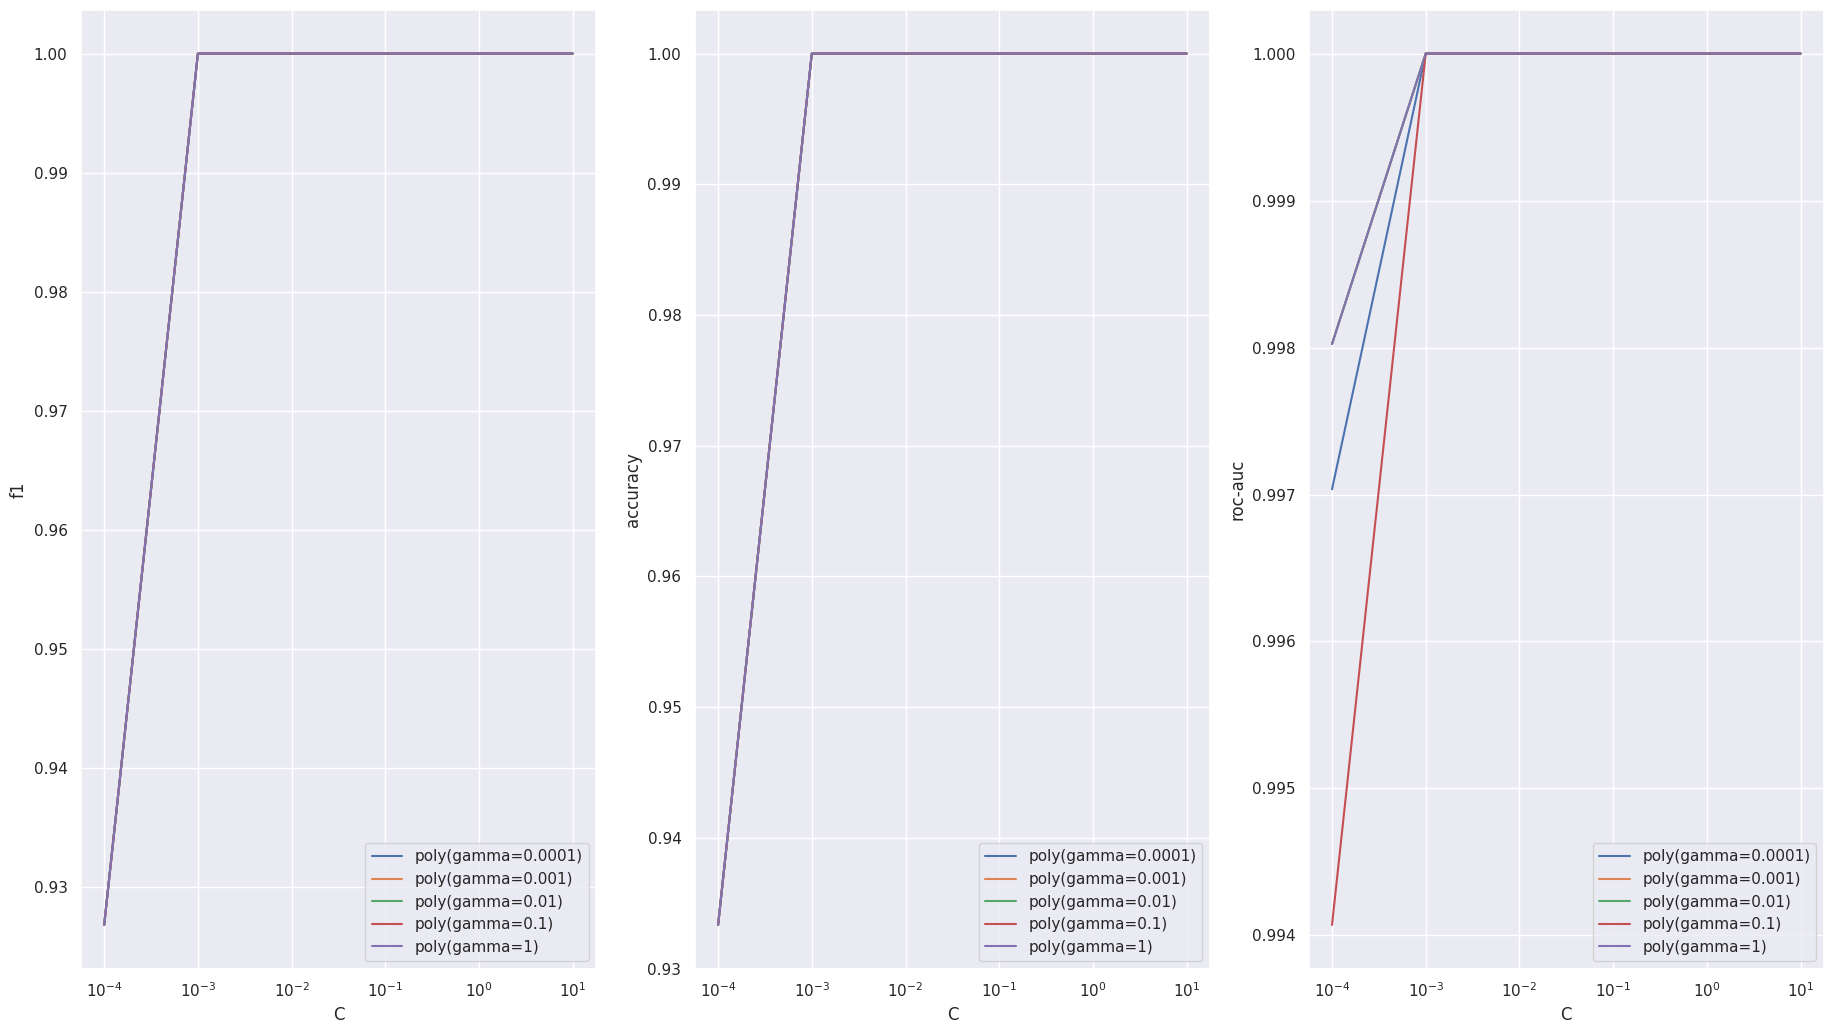

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)

scores = {x: [] for x in metrics}
for g in parameters['gamma']:
    for c in parameters['C']:
        svc = SVC(kernel="poly", gamma=gamma, C=c, probability=True, verbose=False)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        y_pred_proba = svc.predict_proba(X_test)
        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["f1"].append(f1_score(y_test, y_pred))
        scores["roc-auc"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    for i, metric in enumerate(metrics):
        axes[i].plot(parameters['C'], scores[metric], label=f"poly(gamma={g})")
        axes[i].set_xscale("log")
        axes[i].set_xlabel("C")
        axes[i].set_ylabel(metric)
        axes[i].legend(loc="lower right")
        scores[metric].clear()
plt.tight_layout()

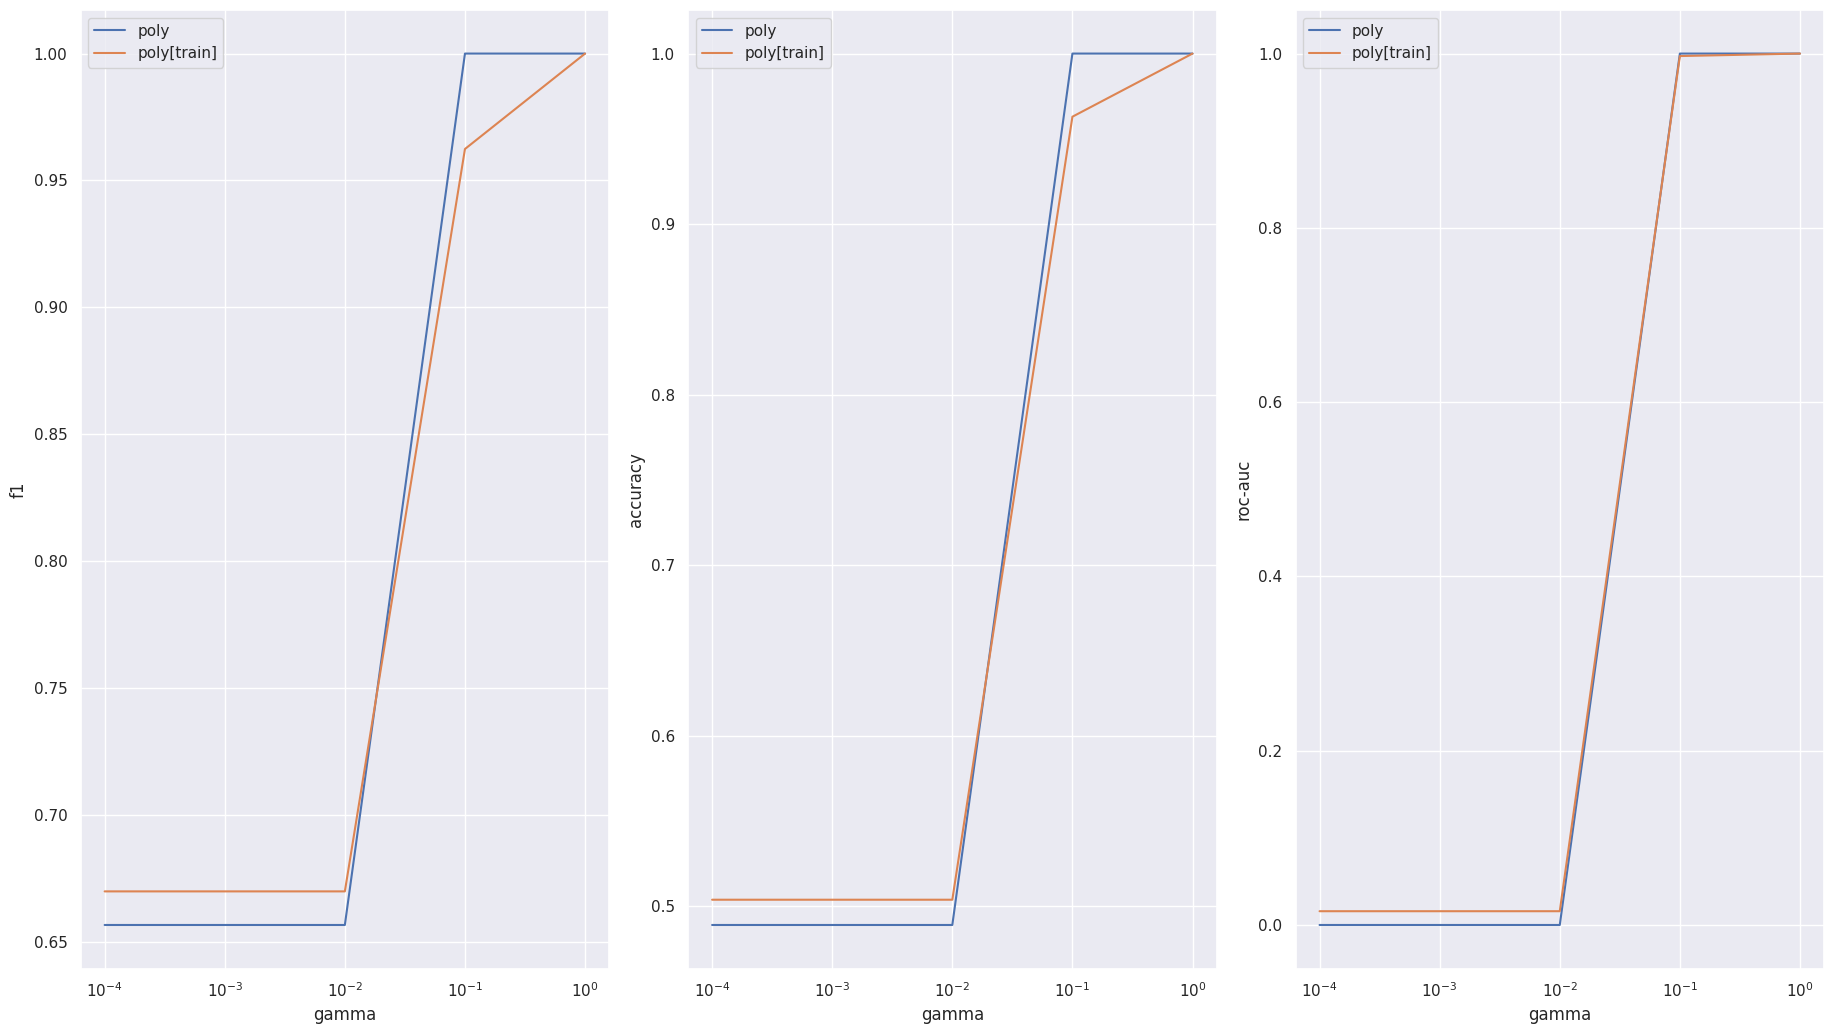

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)

scores = {x: [] for x in metrics}
scores_train = {x: [] for x in metrics}
for gamma in parameters['gamma']:
    svc = SVC(kernel="poly", gamma=gamma, probability=True, verbose=False)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_pred_proba = svc.predict_proba(X_test)
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["f1"].append(f1_score(y_test, y_pred))
    scores["roc-auc"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))

    y_pred_t = svc.predict(X_train)
    y_pred_proba_t = svc.predict_proba(X_train)
    scores_train["accuracy"].append(accuracy_score(y_train, y_pred_t))
    scores_train["f1"].append(f1_score(y_train, y_pred_t))
    scores_train["roc-auc"].append(roc_auc_score(y_train, y_pred_proba_t[:, 1]))
for i, metric in enumerate(metrics):
    axes[i].plot(parameters['gamma'], scores[metric], label=f"poly")
    axes[i].plot(parameters['gamma'], scores_train[metric], label=f"poly[train]")
    axes[i].set_xlabel("gamma")
    axes[i].set_xscale("log")
    axes[i].set_ylabel(metric)
    axes[i].legend(loc="upper left")
    scores[metric].clear()
plt.tight_layout()

Параметр gamma имеет смысл устанавливать либо в 0, либо в 1. Так как промежуточные значения не оказывают сильного влияния

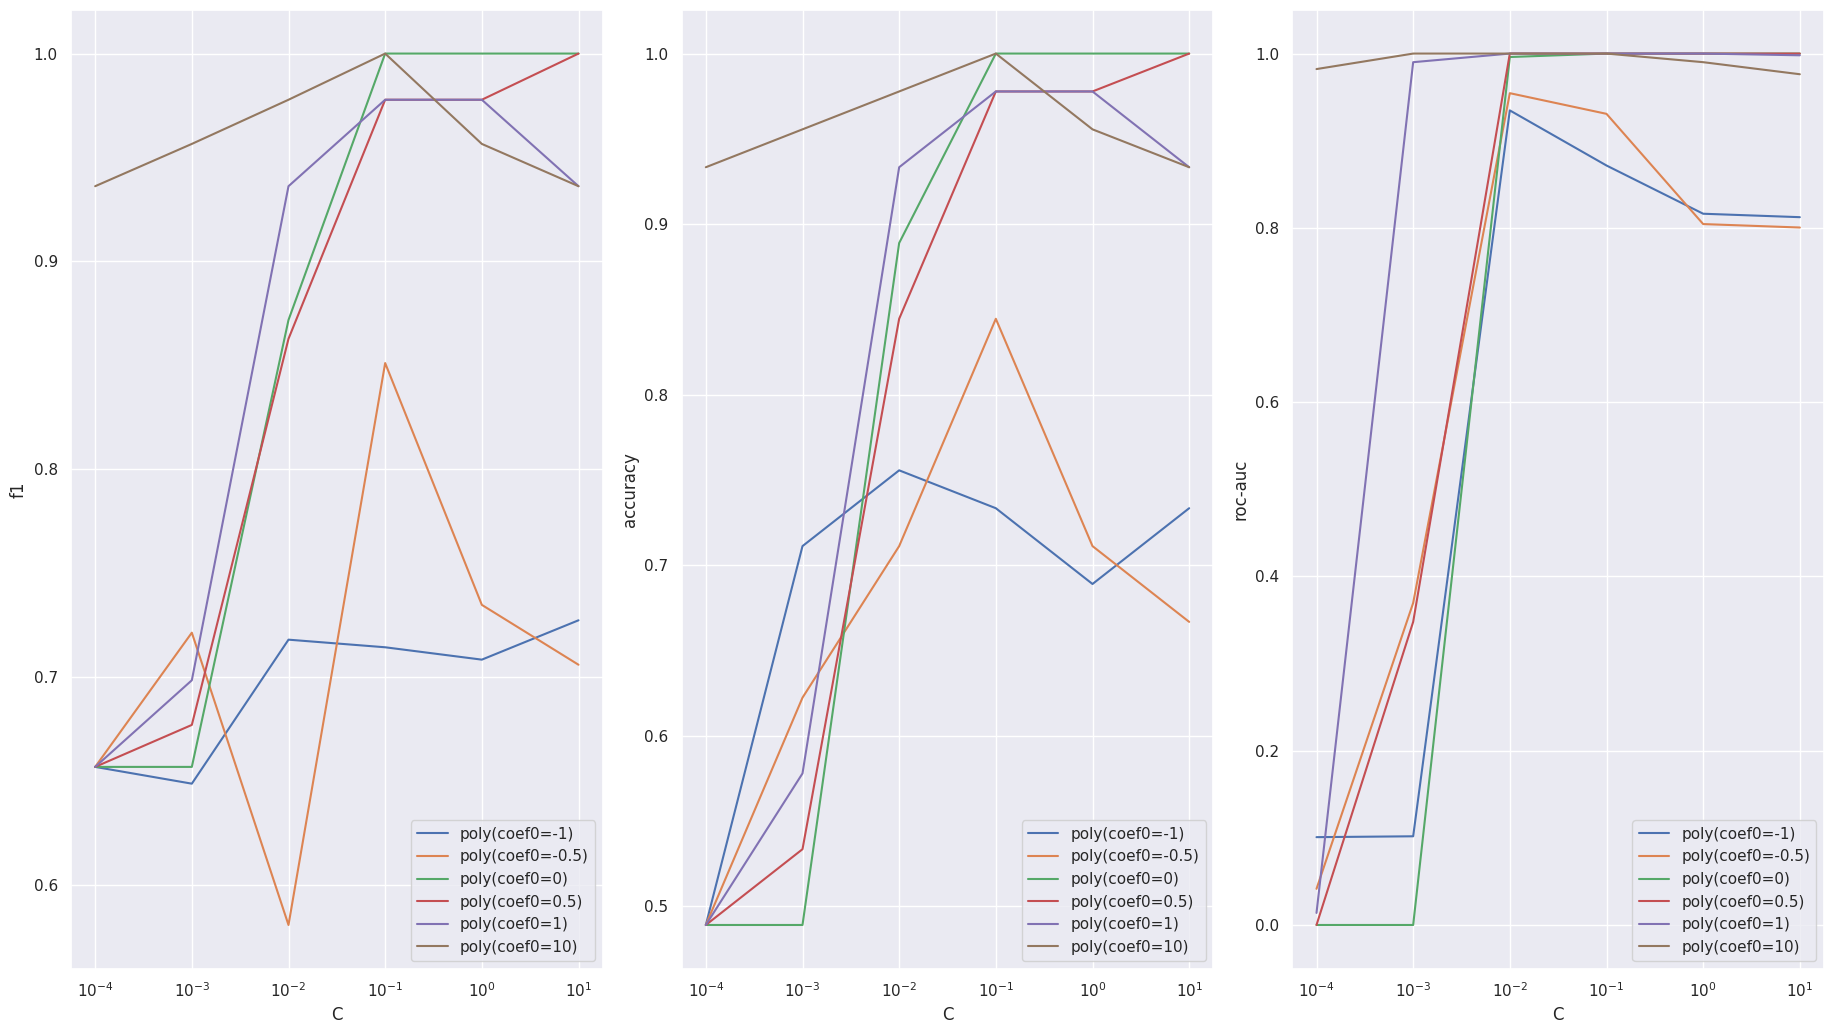

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)

scores = {x: [] for x in metrics}
for coef0 in parameters['coef0']:
    for c in parameters['C']:
        svc = SVC(kernel="poly", coef0=coef0, C=c, probability=True, verbose=False)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        y_pred_proba = svc.predict_proba(X_test)
        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["f1"].append(f1_score(y_test, y_pred))
        scores["roc-auc"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    for i, metric in enumerate(metrics):
        axes[i].plot(parameters['C'], scores[metric], label=f"poly(coef0={coef0})")
        axes[i].set_xscale("log")
        axes[i].set_xlabel("C")
        axes[i].set_ylabel(metric)
        axes[i].legend(loc="lower right")
        scores[metric].clear()
plt.tight_layout()

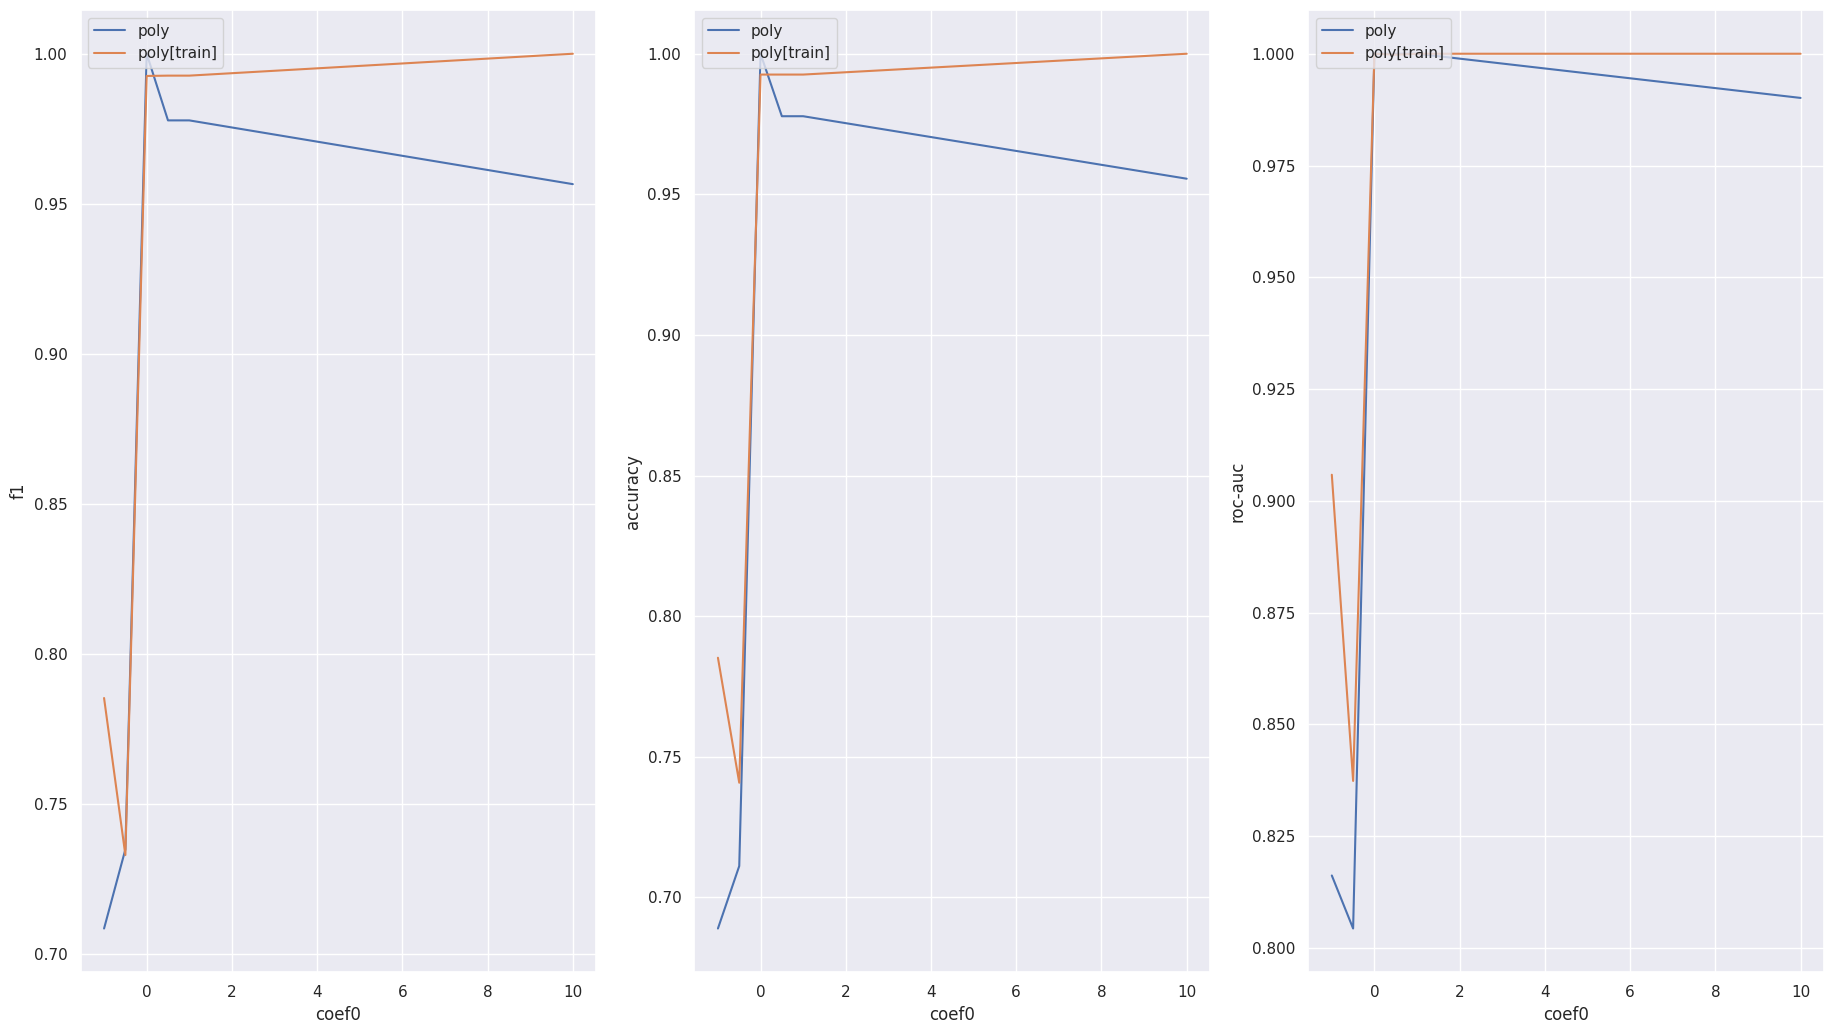

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18.5, 10.5)

scores = {x: [] for x in metrics}
scores_train = {x: [] for x in metrics}
for coef0 in parameters['coef0']:
    svc = SVC(kernel="poly", coef0=coef0, probability=True, verbose=False)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_pred_proba = svc.predict_proba(X_test)

    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["f1"].append(f1_score(y_test, y_pred))
    scores["roc-auc"].append(roc_auc_score(y_test, y_pred_proba[:, 1]))

    y_pred_t = svc.predict(X_train)
    y_pred_proba_t = svc.predict_proba(X_train)
    scores_train["accuracy"].append(accuracy_score(y_train, y_pred_t))
    scores_train["f1"].append(f1_score(y_train, y_pred_t))
    scores_train["roc-auc"].append(roc_auc_score(y_train, y_pred_proba_t[:, 1]))

for i, metric in enumerate(metrics):
    axes[i].plot(parameters['coef0'], scores[metric], label=f"poly")
    axes[i].plot(parameters['coef0'], scores_train[metric], label=f"poly[train]")
    axes[i].set_xlabel("coef0")
    axes[i].set_ylabel(metric)
    axes[i].legend(loc="upper left")
    scores[metric].clear()
plt.tight_layout()

С увеличением coef0 модель начинает переобучаться, при coef=0 такого не происходит и модель показывает сравнимые результаты на тестовой выборке




## Summary
### Переобучение
При стандартных параметрах наиболее сколнными к переобучению оказываются линейное ядро и "rbf". Причем, судя по расхождению линий на графиках, "rbf" чуть более склонна  
###RBF kernel
RBF чувстительно к параметру гамма, с его уменьшением качество модели заметно падает
###Poly kernel
*   В качестве степени лучше всего degree=3
*   Параметр gamma имеет смысл устанавливать либо в 0, либо в 1. Так как промежуточные значения не оказывают сильного влияния
*   С увеличением `coef0` модель начинает переобучаться, при coef=0 такого не происходит и модель показывает сравнимые результаты на тестовой выборке

### По всем моделям
С увеличением коэффициента регуляризации `C` все модели (при остальных параметрах по умолчанию) начинают показывать хороший результат

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

Выбрал следующих авторов: "Gogol", "Lermontov", "Dostoevsky", "Bryusov", "Gorky", "Pushkin"

In [ ]:
!git clone https://github.com/d0rj/RusLit.git

Cloning into 'RusLit'...
remote: Enumerating objects: 570, done.
remote: Counting objects: 100% (570/570), done.
remote: Compressing objects: 100% (515/515), done.
remote: Total 570 (delta 91), reused 527 (delta 50), pack-reused 0
Receiving objects: 100% (570/570), 21.21 MiB | 19.36 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [ ]:
import os

In [ ]:
# https://stackoverflow.com/a/37605851
import nltk

nltk.download('punkt')

def split_to_sentences(text):
    sent_text = nltk.sent_tokenize(text, language="russian")
    return sent_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import textwrap
authors = ["Gogol", "Lermontov", "Dostoevsky", "Bryusov", "Gorky", "Pushkin"]
sentence_data = []
for author in authors:
    for filename in os.listdir(os.path.join("RusLit", "prose", author)):
        if (not filename.endswith("txt")):
            continue
        data = open(os.path.join("RusLit", "prose", author, filename)).read()
        # в официальном чатике курса предложили сделать так
        data = data.replace('\n', ' ')
        result = split_to_sentences(data)
        result = filter(lambda x: len(x) >= 15, result)
        for sentence in result:
            sentence_data.append([sentence, author])


In [ ]:
dataset = pd.DataFrame(sentence_data, columns=["sentence", "author"])
dataset

,sentence,author
0,Николай Васильевич Гоголь Невский проспект ...,Gogol
1,Чем не блестит эта улица -- красавица нашей ст...,Gogol
2,"Я знаю, что ни один из бледных и чиновных ее ж...",Gogol
3,"Не только кто имеет двадцать пять лет от роду,...",Gogol
4,"О, дамам еще больше приятен Невский проспект.",Gogol
...,...,...
217227,"Маркиз Пугачев, о котором вы опять пишете в пи...",Pushkin
217228,"Он оказался таким робким и слабым в тюрьме, чт...",Pushkin
217229,"41 По словам других свидетелей, Перфильев на ...",Pushkin
217230,42 Известие о подробностях мятежа Стеньки Раз...,Pushkin


In [ ]:
dataset.groupby("author").count()

,sentence
author,
Bryusov,24041
Dostoevsky,110919
Gogol,23640
Gorky,45469
Lermontov,3022
Pushkin,10141


In [ ]:
seed = 42
pushkin = dataset[dataset["author"] == "Pushkin"].sample(n=8000, random_state=seed)
lermontov = dataset[dataset["author"] == "Lermontov"].sample(n=3000, random_state=seed)
gogol = dataset[dataset["author"] == "Gogol"].sample(n=5000, random_state=seed)
bryusov = dataset[dataset["author"] == "Bryusov"].sample(n=11000, random_state=seed)
gorky = dataset[dataset["author"] == "Gorky"].sample(n=15000, random_state=seed)
dostoevsky = dataset[dataset["author"] == "Dostoevsky"].sample(n=20000, random_state=seed)

dataset = pd.concat([pushkin, lermontov, gogol, bryusov, gorky, dostoevsky], ignore_index=True)
dataset

,sentence,author
0,"Мысль, что, может быть, вижу ее в последний ра...",Pushkin
1,"Швабрин, Швабрин пуще всего терзал мое воображ...",Pushkin
2,"Я заметил, что ром прояснил его угрюмость.",Pushkin
3,"Выехав из деревни, поднялись они на гору, и Вл...",Pushkin
4,"Нет, батюшка Петр Андреич!",Pushkin
...,...,...
61995,"Но будут, будут, к этому идет… – Жаль тоже...",Dostoevsky
61996,"Если б я только знал, где теперь Колю найти!",Dostoevsky
61997,"Я – я не люблю его, потому что я могу любить т...",Dostoevsky
61998,Если же между петрашевцами и было несколько ра...,Dostoevsky


In [ ]:
import string
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 76.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=5259b48a208fcb71d390a930a5422c5daecc5a40734b373f86d4bd1d137a9f52
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pymorphy2

In [ ]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
word_tokenizer = nltk.WordPunctTokenizer()

morph = pymorphy2.MorphAnalyzer()
def preprocess(value):
    text_lower = value.lower()
    tokens = word_tokenizer.tokenize(text_lower)
    tokens = [morph.parse(word)[0].normal_form for word in tokens if word.isalpha()]
    lemmatized = [word for word in tokens if word not in stop_words]
    return " ".join(lemmatized)

dataset["sentence"] = dataset["sentence"].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset[dataset['author'] == "Dostoevsky"]

,sentence,author
42000,причитание утолять лишь ещё растравлять надрыв...,Dostoevsky
42001,мигом очутиться пред варвара петрович,Dostoevsky
42002,всё человек свет хороший всё единый,Dostoevsky
42003,весь старец это глаз сказать весь это почтенны...,Dostoevsky
42004,городской гость павел семёнович обноскин мать ...,Dostoevsky
...,...,...
61995,идти жаль поглупеть пробормотать ставрогин дви...,Dostoevsky
61996,б знать коля найти,Dostoevsky
61997,любить мочь любить великодушно понимать благор...,Dostoevsky
61998,петрашевец несколько разночинец крайне немного...,Dostoevsky


In [ ]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=100)
vectorizer.fit(dataset["sentence"].tolist())

CountVectorizer(max_features=100)

In [ ]:
vectorized = vectorizer.transform(dataset["sentence"].tolist())
vectorized.todense()[0]

matrix([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
vectorizer = TfidfVectorizer(max_features = 100)
vectorizer.fit(dataset["sentence"].tolist())

TfidfVectorizer(max_features=100)

In [ ]:
vectorized = vectorizer.transform(dataset["sentence"].tolist())
vectorized.todense()[0]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.42888756, 0.        , 0.        , 0.        ,
         0.        , 0.41815545, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.35594681, 0.50595357, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.50844304, 0.        , 0

Прежде всего, вектор, который получается в результате применения метода Bag of words содержит целые числа, а вектор после TF-IDF &mdash; вещественные.  

В методе Bag of words мы сначала определяем N наиболее употребляемых слов, затем, в результате его применения к некоторому предложению получается вектор целых чисел, $i$-ое из которых означает количество появлений в предложении $i$-ого слова из N наиболее употребляемых слов

В методе TF-IDF отношение числа вхождений некоторого слова к общему числу слов документа (в данном случае документ = предложение) умножается на инверсию частоты, с которой некоторое слово встречается в документах коллекции. Так получается вещественный вес для $i$-ого слова в векторе

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

- [x] choose *two* authors from the dataset that you have formed in the previous task
- [x] check the balance of the classes
- [x] divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
- [x] using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
- [x] make several plots to address the dependence between F1 score and parameters
- [x] plot confusion matrix for train and test samples
- [x] compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
- [x] make conclusions about the performance of your models


In [ ]:
df = dataset[(dataset["author"] == "Gogol") | (dataset["author"] == "Lermontov")]
df

,sentence,author
8000,сердце болезненно сжаться первый расставание,Lermontov
8001,умереть долго мучиться измучиться порядок,Lermontov
8002,митька принести шпага,Lermontov
8003,несколько пуля провизжать голова слышать спеши...,Lermontov
8004,любить деньга драть проезжать избаловать мошенник,Lermontov
...,...,...
15995,хороший красавица,Gogol
15996,край лист рукопись оторвать,Gogol
15997,куча жиденковы запачкать оборванный курчавый в...,Gogol
15998,бельведер буквально прекрасный вид башня здание,Gogol


In [ ]:
df["author"].value_counts()

Gogol        5000
Lermontov    3000
Name: author, dtype: int64

Так как мы предварительно сделали датасет в некоторой пропорции. Можно сказать, что классы несбалансированы

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["sentence"], np.array([1 if a == "Gogol" else 0 for a in df["author"].tolist()]), test_size=0.3, random_state=42, stratify=df["author"])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(df["sentence"].tolist())

TfidfVectorizer(max_features=1000)

In [ ]:
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
svc_parameters = {
    'kernel':['linear', 'poly', 'rbf'],
    'C':[0.001, 0.01, 0.1, 1],
    'degree': [1, 2, 3],
    'gamma': [0.01, 0.1, 1]
}
svr = SVC(probability=True, verbose = False)
gscv = GridSearchCV(svr, svc_parameters, scoring = 'f1_macro', cv=2, verbose=2, n_jobs=-1)
gscv.fit(X_train_vec, y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


GridSearchCV(cv=2, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'degree': [1, 2, 3],
                         'gamma': [0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1_macro', verbose=2)

In [ ]:
logit_parameters = {
    'beta':  [0, 0.01, 0.1, 1],
    'gamma':  [0, 0.01, 0.1, 1],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'tolerance': [0.00001, 0.0001, 0.001]
}
clf_logit = Logit()
gscl = GridSearchCV(clf_logit, logit_parameters, scoring = 'f1_macro', cv=2, verbose=2, n_jobs=-1)
gscl.fit(X_train_vec.todense(), y_train)

Fitting 2 folds for each of 192 candidates, totalling 384 fits


GridSearchCV(cv=2, estimator=Logit(), n_jobs=-1,
             param_grid={'beta': [0, 0.01, 0.1, 1], 'gamma': [0, 0.01, 0.1, 1],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'tolerance': [1e-05, 0.0001, 0.001]},
             scoring='f1_macro', verbose=2)

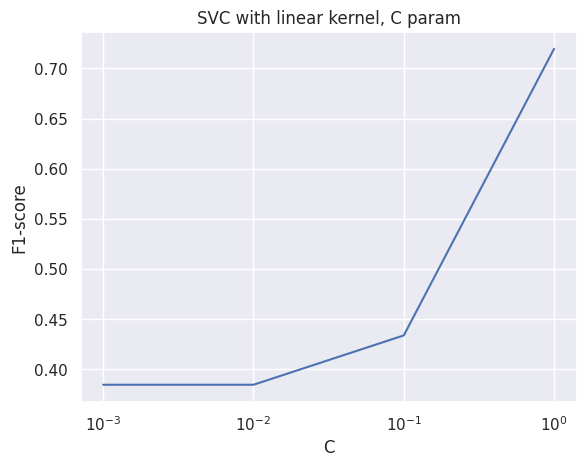

In [ ]:
rs = pd.DataFrame(gscv.cv_results_)
linear = rs[rs["param_kernel"] == "linear"]
plt.plot(linear["param_C"].unique(), linear.groupby(f"param_C")["mean_test_score"].mean())
plt.xscale("log")
plt.ylabel("F1-score")
plt.xlabel("C")
plt.title(f"SVC with linear kernel, C param")
plt.show()

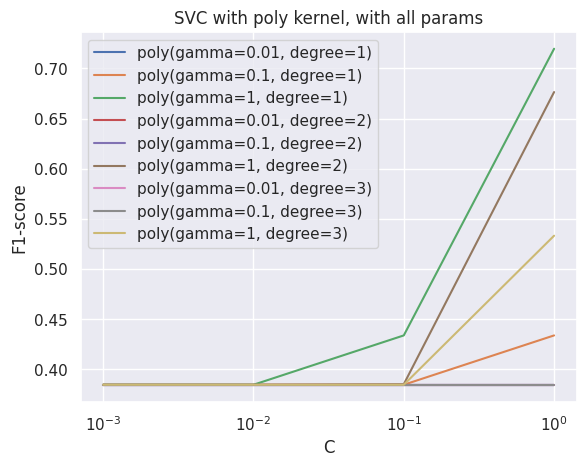

In [ ]:
poly = rs[rs["param_kernel"] == "poly"]
for degree in poly["param_degree"].unique():
    for gamma in poly["param_gamma"].unique():
        sp_data = poly[(poly["param_gamma"] == gamma) & (poly["param_degree"] == degree)]
        plt.plot(sp_data["param_C"].unique(), sp_data.groupby(f"param_C")["mean_test_score"].mean(), label=f"poly(gamma={gamma}, degree={degree})")
plt.xscale("log")
plt.ylabel("F1-score")
plt.xlabel("C")
plt.title(f"SVC with poly kernel, with all params")
plt.legend(loc="upper left")
plt.show()

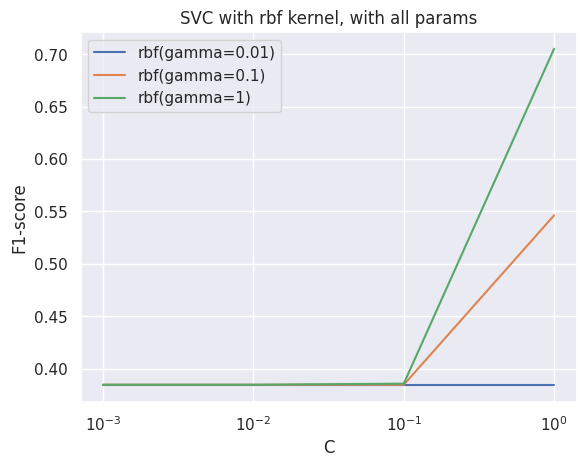

In [ ]:
rbf = rs[rs["param_kernel"] == "rbf"]
for gamma in rbf["param_gamma"].unique():
    sp_data = rbf[rbf["param_gamma"] == gamma]
    plt.plot(sp_data["param_C"].unique(), sp_data.groupby(f"param_C")["mean_test_score"].mean(), label=f"rbf(gamma={gamma})")
plt.xscale("log")
plt.ylabel("F1-score")
plt.xlabel("C")
plt.title(f"SVC with rbf kernel, with all params")
plt.legend(loc="upper left")
plt.show()

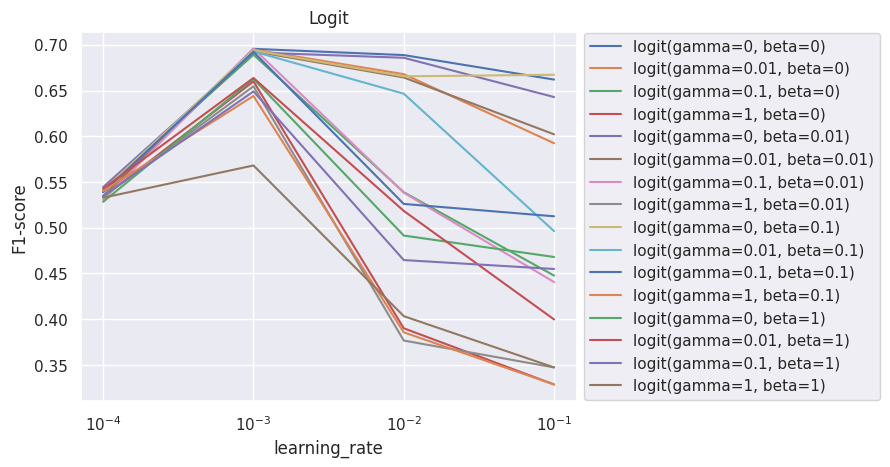

In [ ]:
rl = pd.DataFrame(gscl.cv_results_)
for beta in rl["param_beta"].unique():
    for gamma in rl["param_gamma"].unique():
        sp_data = rl[(rl["param_gamma"] == gamma) & (rl["param_beta"] == beta)]
        plt.plot(sp_data["param_learning_rate"].unique(), sp_data.groupby(f"param_learning_rate")["mean_test_score"].mean(), label=f"logit(gamma={gamma}, beta={beta})")
plt.xscale("log")
plt.ylabel("F1-score")
plt.xlabel("learning_rate")
plt.title(f"Logit")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

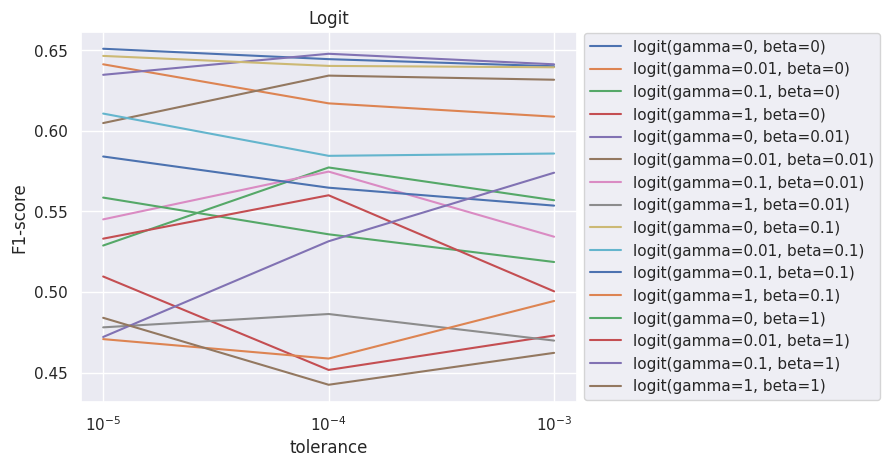

In [ ]:
rl = pd.DataFrame(gscl.cv_results_)
for beta in rl["param_beta"].unique():
    for gamma in rl["param_gamma"].unique():
        sp_data = rl[(rl["param_gamma"] == gamma) & (rl["param_beta"] == beta)]
        plt.plot(sp_data["param_tolerance"].unique(), sp_data.groupby(f"param_tolerance")["mean_test_score"].mean(), label=f"logit(gamma={gamma}, beta={beta})")
plt.xscale("log")
plt.ylabel("F1-score")
plt.xlabel("tolerance")
plt.title(f"Logit")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
print(f"Logit best: {gscl.best_params_}\nSVC best: {gscv.best_params_}")

Logit best: {'beta': 0, 'gamma': 0, 'learning_rate': 0.001, 'tolerance': 0.001}
SVC best: {'C': 1, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear'}


In [ ]:
best_logit = Logit(**gscl.best_params_)
svc_params = gscv.best_params_
svc_params["probability"] = True
best_svc = SVC(**svc_params)
best_logit.fit(X_train_vec.todense(), y_train)
best_svc.fit(X_train_vec, y_train)

SVC(C=1, degree=1, gamma=0.01, kernel='linear', probability=True)

In [ ]:
# Из семинарского ноутбука
def show_results(test_y, pred, proba, m=False):
    if m:
        print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
        print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
        print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
        print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
        print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba)))
        print('\n')

    if not m:
        plt.clf()
        labels = ['Lermontov','Gogol']

        #classification_report
        sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
        plt.title("Confusion matrix ")
        plt.show()

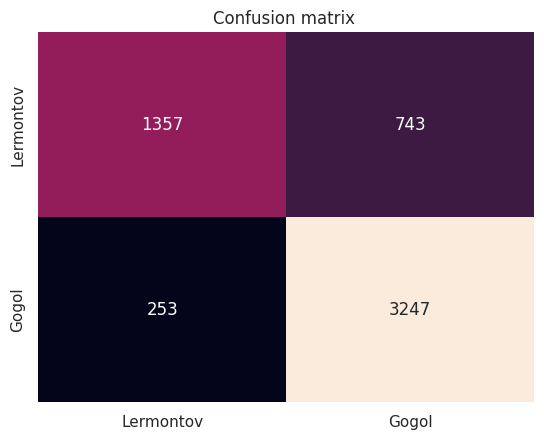

In [ ]:
predict_logit = best_logit.predict(X_train_vec.todense())
proba_logit = best_logit.predict_proba(X_train_vec.todense())

show_results(y_train, predict_logit, proba_logit[1, :])

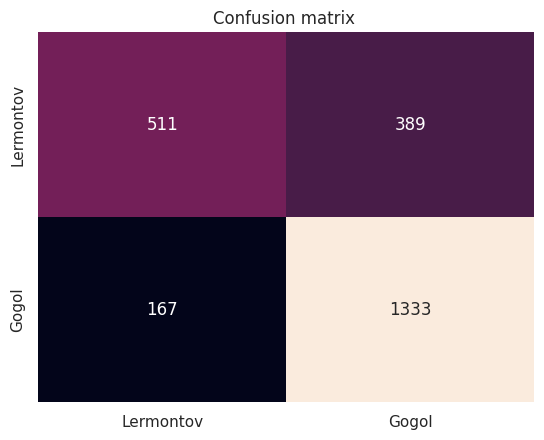

In [ ]:
predict_logit = best_logit.predict(X_test_vec.todense())
proba_logit = best_logit.predict_proba(X_test_vec.todense())

show_results(y_test, predict_logit, proba_logit[1, :])

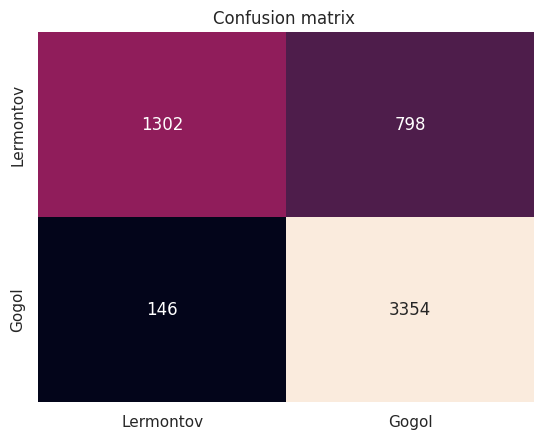

In [ ]:
predict_svc = best_svc.predict(X_train_vec)
proba_svc = best_svc.predict_proba(X_train_vec)

show_results(y_train, predict_svc, proba_svc[:, 1])

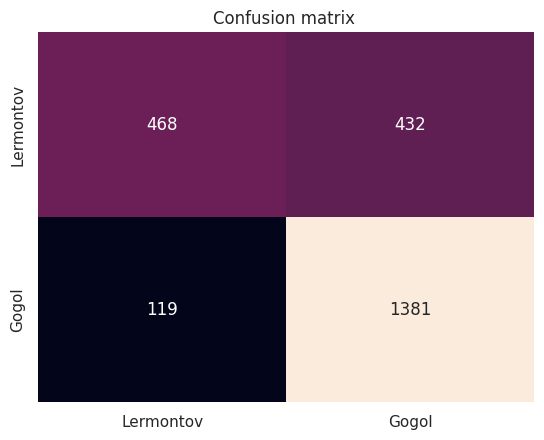

In [ ]:
predict_svc = best_svc.predict(X_test_vec)
proba_svc = best_svc.predict_proba(X_test_vec)

show_results(y_test, predict_svc, proba_svc[:, 1])

In [ ]:
show_results(y_test, predict_svc, proba_svc[:, 1], m=True)

Precision:   0.78
Recall:   0.72
F1-measure:   0.73
Accuracy:   0.77
ROC-AUC  =    0.83




In [ ]:
show_results(y_test, predict_logit, proba_logit[1, :], m=True)

Precision:   0.76
Recall:   0.73
F1-measure:   0.74
Accuracy:   0.77
ROC-AUC  =    0.84




Согласно полученным результатам, самописная логистическая регрессия по качеству сравнима с SVC из sklearn. Все метрики показывают значение не ниже 0.7, что является хорошим результатом

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

Threshold that logit have no more than 30% of false positive errors rate: 0.6099892933004598


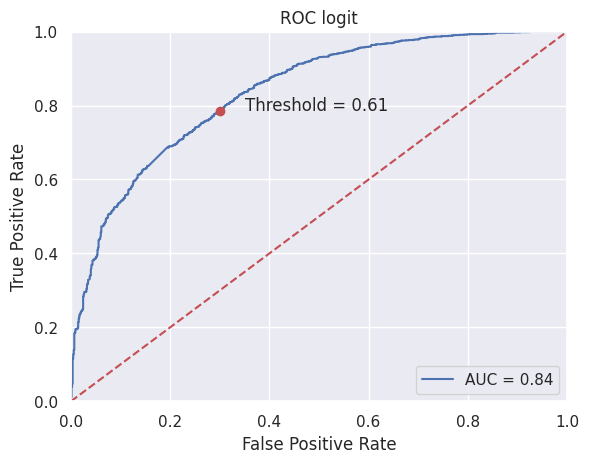

In [ ]:
# https://stackoverflow.com/a/38467407
import sklearn.metrics as metrics
probs = proba_logit
preds = probs[1, :]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
idx = np.argmax(fpr[fpr <= 0.3])
plt.title('ROC logit')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr[idx], tpr[idx], "ro")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.annotate(f"Threshold = {np.round(threshold[idx], 3)}", (fpr[idx] + 0.05, tpr[idx]))
print(f"Threshold that logit have no more than 30% of false positive errors rate: {threshold[idx]}")
plt.show()

Threshold that SVC have no more than 30% of false positive errors rate: 0.6616095826937191


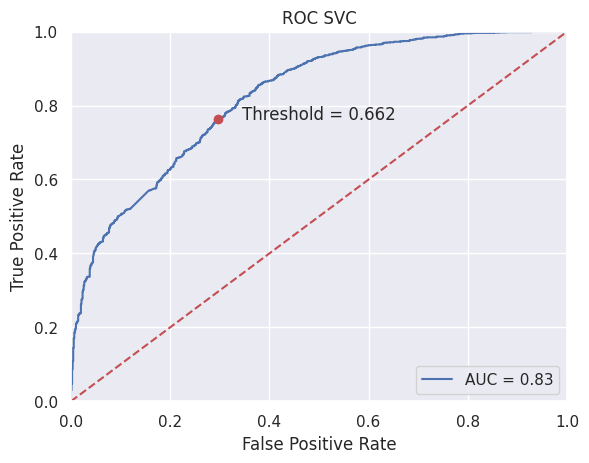

In [ ]:
# https://stackoverflow.com/a/38467407
import sklearn.metrics as metrics
probs = proba_svc
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
idx = np.argmax(fpr[fpr <= 0.3])
plt.title('ROC SVC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr[idx], tpr[idx], "ro")
plt.annotate(f"Threshold = {np.round(threshold[idx], 3)}", (fpr[idx] + 0.05, tpr[idx]))
print(f"Threshold that SVC have no more than 30% of false positive errors rate: {threshold[idx]}")
plt.show()

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset["sentence"], dataset["author"], test_size=0.3, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(max_features = 1000)
vectorizer.fit(dataset["sentence"].tolist())
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
mapping = {x: authors.index(x) for x in authors}
y_train = y_train.apply(lambda x: mapping[x])
y_test = y_test.apply(lambda x: mapping[x])

In [ ]:
y_test.value_counts

<bound method IndexOpsMixin.value_counts of 37319    4
3593     5
17933    3
3050     5
61238    2
        ..
32613    4
17663    3
54828    2
35217    4
6342     5
Name: author, Length: 18600, dtype: int64>

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression

parameters = {'estimator__C': [0.001, 0.01, 0.1, 1]}
svr = OneVsOneClassifier(LogisticRegression(verbose = False), n_jobs=-1)
clf = GridSearchCV(svr, parameters, scoring="f1_macro")
clf.fit(X_train_vec, y_train)

GridSearchCV(estimator=OneVsOneClassifier(estimator=LogisticRegression(verbose=False),
                                          n_jobs=-1),
             param_grid={'estimator__C': [0.001, 0.01, 0.1, 1]},
             scoring='f1_macro')

In [ ]:
pred = clf.predict(X_test_vec)

Precision:   0.57
Recall:   0.39
F1-measure:   0.41
Accuracy:   0.53




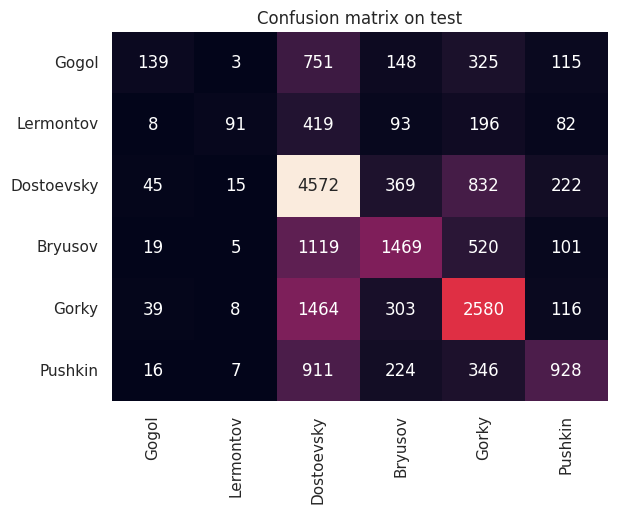

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
# print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
print('\n')
#classification_report
sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=authors, yticklabels=authors)
plt.title("Confusion matrix on test")
plt.show()

In [ ]:
pred_t = clf.predict(X_train_vec)

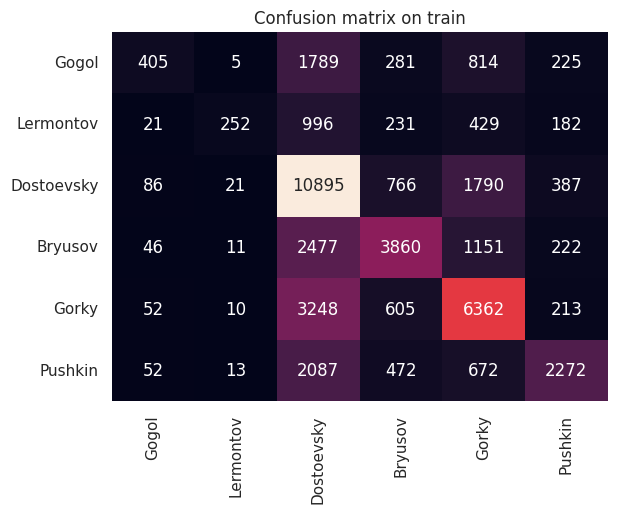

In [ ]:
sns.heatmap(data=confusion_matrix(y_train, pred_t), annot=True, fmt="d", cbar=False, xticklabels=authors, yticklabels=authors)
plt.title("Confusion matrix on train")
plt.show()